In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import brutefit as bf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.optimize as opt
import matplotlib.pyplot as plt
import cbsyst as cb
from b_funks.helpers import isolate_constant_conditions
from b_funks.previous_models import fit_data_with_previous_models

import uncertainties as un
import uncertainties.unumpy as unp
nom = unp.nominal_values
err = unp.std_devs

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import brutefit as bf
from sklearn.preprocessing import StandardScaler

from uncertainties import unumpy as unp
from b_funks import load

nom = unp.nominal_values
err = unp.std_devs

plt.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
odat = load.b_data(None)
dat = load.b_data()

In [4]:
# odat = pd.read_csv('data/B_compiled.csv', index_col=0, header=[0,1])

# # package uncertainties
# odat.loc[:, ('Measured', 'B/Caf')] = unp.uarray(odat.loc[:, ('Measured', 'B/Caf')], odat.loc[:, ('Uncertainties', 'se')])

# odat.loc[:, ('Measured', 'KB')] = odat.loc[:, ('Measured', 'B/Caf')] / (odat.loc[:, ('Measured', '[B]sw')] / odat.loc[:, ('csys_mid', 'DIC')])
# odat.loc[:, ('Measured', 'KB_HCO3')] = odat.loc[:, ('Measured', 'B/Caf')] / (odat.loc[:, ('Measured', '[B]sw')] / odat.loc[:, ('csys_mid', 'HCO3')])

# # normalise B/Ca to ambient [B] - this is a linear correction, see Allen et al (2011) Fig 2
# # B_ambient = 416.
# # odat.loc[:, ('Measured', 'B/Caf_corr')] = odat.loc[:, ('Measured', 'B/Caf')] * B_ambient / odat.loc[:, ('Measured', '[B]sw')]
# # odat.loc[:, ('Measured', 'KB_corr')] = odat.loc[:, ('Measured', 'B/Caf_corr')] / (B_ambient / odat.loc[:, ('csys_mid', 'DIC')])
# # re-calculated carbon system to ambient [B]

# # for c in odat.csys_mid.columns:
# #     odat.loc[:, ('csys_mid_corr', c)] = odat.loc[:, ('csys_mid', c)]
# # odat.loc[:, ('csys_mid_corr', 'f_BT')] = B_ambient / odat[('csys_mid', 'BT')]
# # odat.loc[:, ('csys_mid_corr', 'TA')] = odat[('csys_mid', 'TA')] - odat[('csys_mid', 'BO4')] + odat[('csys_mid', 'BO4')] * odat[('csys_mid_corr', 'f_BT')]

# # for c in ['BT', 'BO3', 'BO4']:
# #     odat.loc[:, ('csys_mid_corr', c)] *= odat.loc[:, ('csys_mid_corr', 'f_BT')]

# # a few derived parameters
# odat[('csys_mid', 'del_CO3')] = 1e6 * odat[('csys_mid', 'KspC')] / (1e-3 * odat[('Measured', '[Ca]sw')])
# # odat[('csys_mid_corr', 'del_CO3')] = 1e6 * odat[('csys_mid_corr', 'KspC')] / (1e-3 * odat[('Measured', '[Ca]sw')])

# odat[('csys_mid', 'BT_DIC')] = odat[('csys_mid', 'BT')] / odat[('csys_mid', 'DIC')]
# # odat[('csys_mid_corr', 'BT_DIC')] = odat[('csys_mid_corr', 'BT')] / odat[('csys_mid_corr', 'DIC')]

# # comment out studies here to remove them
# mdict = {
#     'This Study': 'o', 
#     'Haynes et al. (2017)': 's', 
#     'Allen et al. (2011)': 'd',
#     'Howes et al. (2017)': '*'
# }

# kdat = odat.loc[odat.loc[:, ('Measured', 'who')].isin(['This Study'])]
# dat = odat.loc[odat.loc[:, ('Measured', 'who')].isin(mdict)]

## Pairs of Parameters for KB denominator:
 - B, DIC
 - B, HCO3
 - B, CO3
 - BO4, DIC
 - BO4, HCO3
 - BO4, CO3
 
Extra parameters:
<!--  - Sal -->
<!--  - Temp -->
 - Ca
 - Mg
 - Omega
 - CO3
 - DIC
 - pH

## Fitting B/Ca

This is innapropriate because the objective function is:

$$
y = f(\dots) + m R
$$
where R is the solution ratio of interest.

To convert this to KB:
$$
K_B = \frac{y}{R} = \frac{f(\dots)}{R} + m
$$
Which is not a sensible functional form.

In [5]:
extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
    ('csys_mid', 'Omega'),
    ('csys_mid', 'CO3'),
    ('csys_mid', 'DIC'),
    ('csys_mid', 'pHtot')
]

brutes = {}

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
w = 1 / err(dat.loc[:, ('Measured', 'B/Caf')])**2

for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        ratio = f'{b}_{c}'
        print(ratio)
        candidates = dat.loc[:, extras]
        candidates.loc[:, ('deriv', ratio)] = dat.loc[:, ('csys_mid', b)] / dat.loc[:, ('csys_mid', c)]
        brutes[ratio] = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, Scaler=StandardScaler)
        _ = brutes[ratio].evaluate_polynomials()

BT_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BT_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BT_CO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BO4_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BO4_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BO4_CO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

In [6]:
# aggregate fits
df = []
for r, b in brutes.items():
    tdf = b.modelfits
    tdf['r'] = r
    df.append(tdf)
         
df = pd.concat(df)

# calculate global metrics
df.loc[:, ('metrics', 'BF_max')] = df.loc[:, ('metrics', 'BF0')] / df.loc[:, ('metrics', 'BF0')].max()
df.loc[:, ('metrics', 'K')] = 1 / df.loc[:, ('metrics', 'BF_max')]
df.loc[:, ('metrics', 'evidence_against')] = None

df.sort_values(('metrics', 'K'), inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df.head()

coefs                                                         p_values  \
          C X0^1 X1^1 X2^1      X3^1      X4^1      X5^1      X6^1         C   
0 -0.175956  NaN  NaN  NaN  0.069752       NaN       NaN  0.922772  0.029821   
1 -0.139476  NaN  NaN  NaN  0.056147  0.147524       NaN  0.939259  0.069889   
2 -0.147353  NaN  NaN  NaN       NaN  0.169352       NaN  0.942490  0.070267   
3 -0.193061  NaN  NaN  NaN       NaN       NaN       NaN  0.923792  0.029039   
4 -0.154730  NaN  NaN  NaN  0.191159       NaN -0.108877  0.932341  0.048984   

        ...                                     metrics                     \
  X0^1  ...      X4^1      X5^1          X6^1        R2                BF0   
0  NaN  ...       NaN       NaN  4.285461e-13  0.820361  1088301095.786583   
1  NaN  ...  0.130676       NaN  5.842216e-12  0.839597   719928559.762348   
2  NaN  ...  0.081138       NaN  2.143552e-11  0.814267   678033777.088627   
3  NaN  ...       NaN       NaN  2.423617e-12  0.778837   462321821.310796   
4  NaN  ...       NaN  0.393142  3.460254e-11  0.834241   460030815.956268   

                                                           r  
  n_covariates    BF_max         K evidence_against           
0          2.0       1.0       1.0             None  BT_HCO3  
1          3.0  0.661516  1.511679             None  BT_HCO3  
2          2.0   0.62302  1.605084             None  BT_HCO3  
3          1.0  0.424811   2.35399             None  BT_HCO3  
4          3.0  0.422705  2.365713             None  BT_HCO3  

[5 rows x 23 columns]

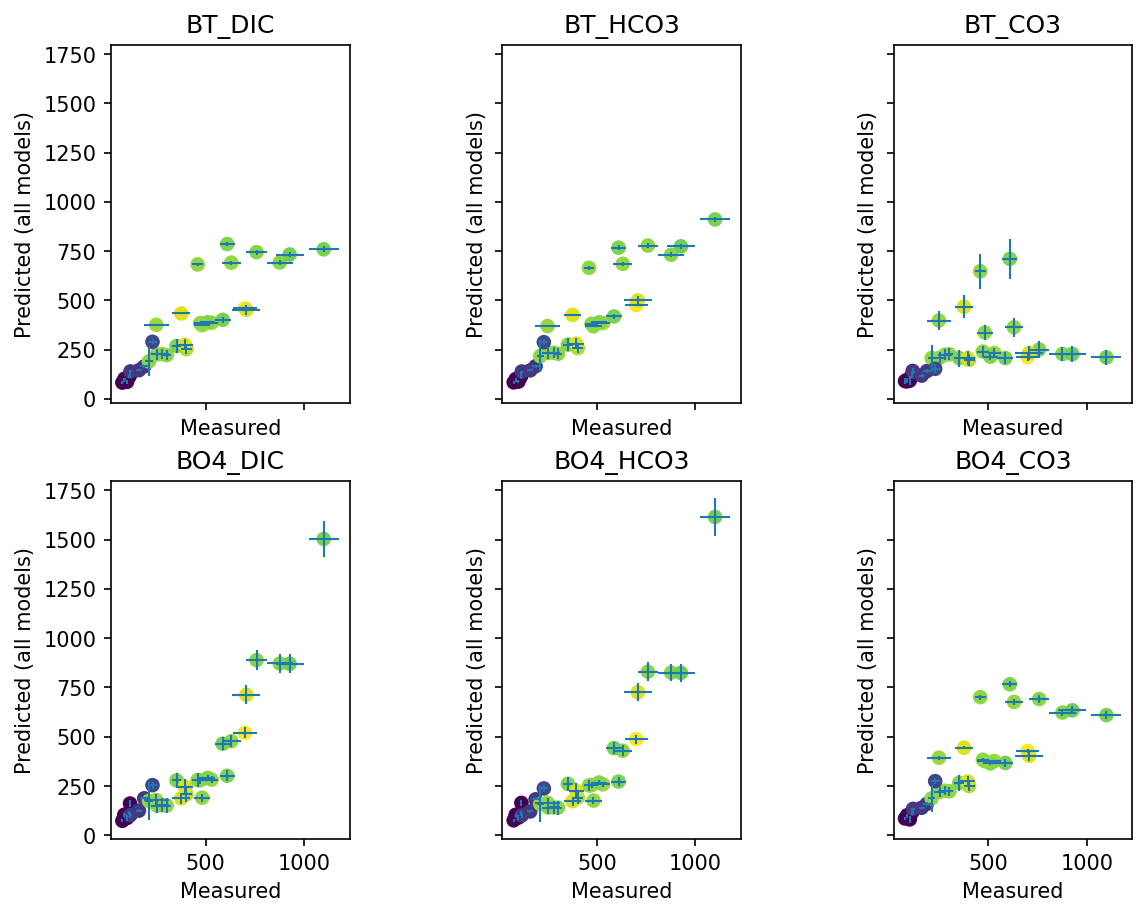

In [8]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], sharex=True, sharey=True, constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    brutes[k].plot_obs_vs_pred(ax=ax, c=dat[('Measured', '[B]sw')].values)
    ax.set_title(k)

The main driver of all patterns is $[B]_{SW}$ - must fit KB. It's not surprising we can't fit B/Ca well including a solution ratio, beause the objective function is daft. 

## Fitting KB (B/DIC)

This is more useful, with the objective function:
$$
K_B = \frac{y}{R} = f(\dots)
$$
which converts to B/Ca:
$$
y = R~f(\dots)
$$

In [9]:
extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     ('csys_mid', 'Omega'),
    ('csys_mid', 'BO4'),
    ('csys_mid', 'BT'),
    ('csys_mid', 'CO3'),
    ('csys_mid', 'pHtot'),
    ('csys_mid', 'DIC'),
#     ('csys_mid', 'del_CO3'),
]

y = nom(dat.loc[:, ('Measured', 'KB')])
w = 1 / err(dat.loc[:, ('Measured', 'KB')])**2
# y = dat.loc[:, ('Measured', 'B/Caf')] / (dat.loc[:, ('csys_mid', 'BT')] / dat.loc[:, ('csys_mid', 'HCO3')])

candidates = dat.loc[:, extras]
kbrutes = bf.Brute(X=candidates.values, y=y, varnames=[c[1] for c in candidates.columns], w=w, max_interaction_order=0, Scaler=StandardScaler)
df = kbrutes.evaluate_polynomials()

Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

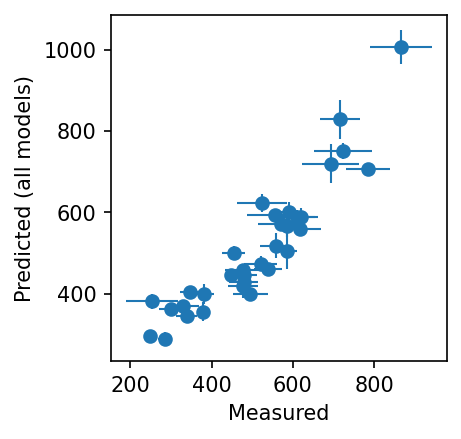

In [10]:
kbrutes.plot_obs_vs_pred()

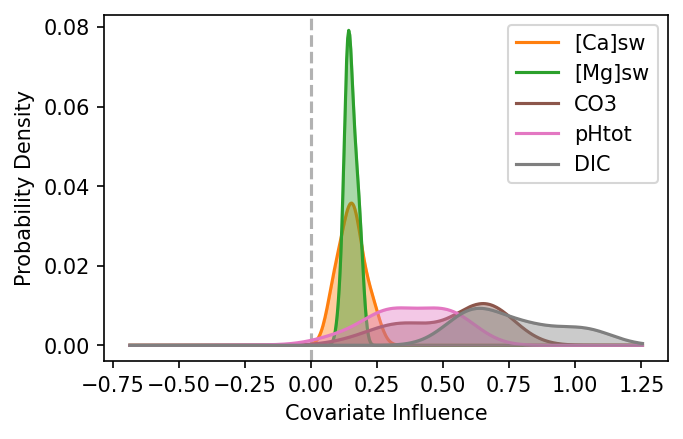

In [11]:
kbrutes.plot_param_dists(filter_zeros=0.05)
plt.legend()

Text(0.05, 0.95, 'R2: 0.961')

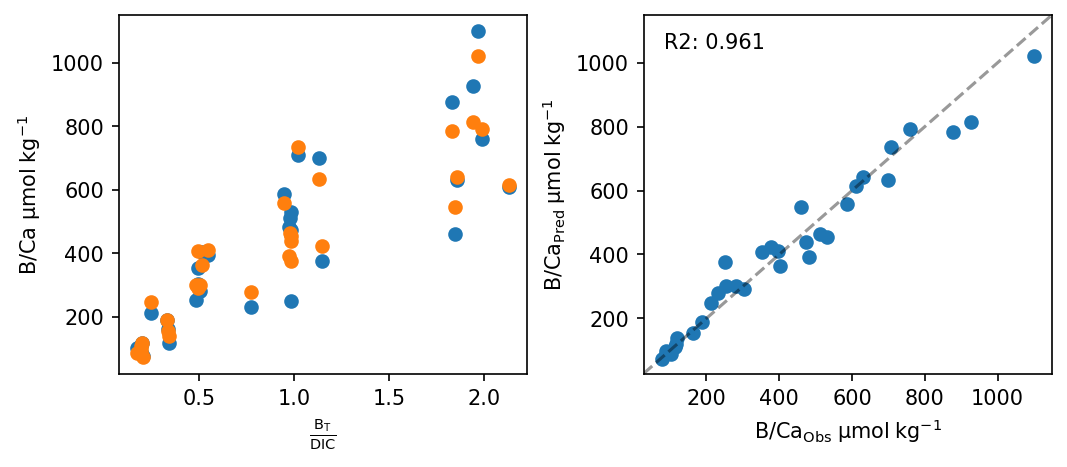

In [12]:
# How well can this predicted KB reproduce B/Ca?
pred_BCa = kbrutes.pred_means * (dat.csys_mid.BT / dat.csys_mid.DIC)

fig, axs = plt.subplots(1, 2, figsize=[7,3], constrained_layout=True)

ax = axs[0]
ax.scatter(dat.csys_mid.BT / dat.csys_mid.DIC, nom(dat.loc[:, ('Measured', 'B/Caf')]), label='Measured')
ax.scatter(dat.csys_mid.BT / dat.csys_mid.DIC, pred_BCa, label='Predicted')
ax.set_xlabel(r'$\frac{B_T}{DIC}$')
ax.set_ylabel(r'B/Ca $\mu mol~kg^{-1}$')

ax = axs[1]
ax.scatter(nom(dat.loc[:, ('Measured', 'B/Caf')]), pred_BCa)
ax.set_xlabel(r'$B/Ca_{Obs} ~\mu mol~kg^{-1}$')
ax.set_ylabel(r'$B/Ca_{Pred} ~\mu mol~kg^{-1}$')

lim = ax.get_xlim()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, ls='dashed', color=(0,0,0,0.4))

r2 = bf.stats.calc_R2(nom(dat.loc[:, ('Measured', 'B/Caf')]), pred_BCa)
ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

In [13]:
# pd.plotting.scatter_matrix(dat.loc[:, extras], figsize=[16,16], diagonal='kde');

In [14]:
kbrutes.varnames

['[Ca]sw', '[Mg]sw', 'BO4', 'BT', 'CO3', 'pHtot', 'DIC']

In [15]:
df.head(10)

coefs                                                              \
          C      X0^1      X1^1      X2^1      X3^1      X4^1      X5^1   
0  0.040858       NaN  0.136920       NaN       NaN  0.663647       NaN   
1  0.004758       NaN       NaN       NaN       NaN  0.651076       NaN   
2  0.049287       NaN  0.164254       NaN       NaN  0.331062  0.278893   
3  0.044776       NaN  0.185346       NaN       NaN       NaN  0.509326   
4  0.001405  0.139952       NaN       NaN       NaN  0.692072       NaN   
5 -0.000610       NaN  0.148168       NaN -0.071377  0.661734       NaN   
6  0.032467  0.088485  0.113135       NaN       NaN  0.687383       NaN   
7  0.008282       NaN  0.175211       NaN -0.070500  0.331024  0.277340   
8  0.035642  0.180465  0.144017       NaN       NaN       NaN  0.574614   
9  0.028392       NaN  0.147753  0.355081 -0.237142  0.439842       NaN   

             p_values            ...                                        \
       X6^1         C      X0^1  ...      X3^1          X4^1          X5^1   
0  0.601055  0.610835       NaN  ...       NaN  1.117250e-08           NaN   
1  0.618380  0.955513       NaN  ...       NaN  5.304009e-08           NaN   
2  0.819752  0.525985       NaN  ...       NaN  8.536160e-02  1.339425e-01   
3  1.036654  0.590059       NaN  ...       NaN           NaN  1.894279e-06   
4  0.610151  0.986492  0.103622  ...       NaN  1.018822e-08           NaN   
5  0.573085  0.993865       NaN  ...  0.379746  9.975704e-09           NaN   
6  0.598862  0.685270  0.309208  ...       NaN  5.636259e-09           NaN   
7  0.790908  0.913604       NaN  ...  0.367521  8.110329e-02  1.304472e-01   
8  1.064429  0.656685  0.044191  ...       NaN           NaN  1.369175e-07   
9  0.734715  0.710356       NaN  ...  0.066924  5.525815e-03           NaN   

                  metrics                                                     \
           X6^1        R2               BF0 n_covariates    BF_max         K   
0  8.031854e-08  0.816703  117092744.758442          3.0       1.0       1.0   
1  1.445057e-07  0.785155   86396909.406932          2.0   0.73785  1.355289   
2  2.311030e-06   0.83454   76176349.007772          4.0  0.650564  1.537127   
3  1.736389e-13  0.803699    46214207.79622          3.0   0.39468  2.533696   
4  1.146872e-07   0.80331   44990115.593372          3.0  0.384226  2.602633   
5  1.978993e-07  0.826642     41497658.9949          4.0    0.3544  2.821671   
6  9.111643e-08   0.82355   32971432.679593          4.0  0.281584  3.551339   
7  3.456609e-06   0.84515   32420664.583597          5.0   0.27688   3.61167   
8  5.062617e-14  0.823313   32401354.256174          4.0  0.276715  3.613823   
9  1.698096e-06   0.84498   31980407.253786          5.0   0.27312   3.66139   

                                       
                     evidence_against  
0                          Best Model  
1  Not worth more than a bare mention  
2  Not worth more than a bare mention  
3  Not worth more than a bare mention  
4  Not worth more than a bare mention  
5  Not worth more than a bare mention  
6         Substantially less probably  
7         Substantially less probably  
8         Substantially less probably  
9         Substantially less probably  

[10 rows x 22 columns]

## Fitting KB (denominator agnosticator)

In [16]:
dat.Measured.who.unique()

array(['This Study'], dtype=object)

In [17]:
# dat = odat
# dat = odat.loc[~odat.Measured.who.isin(['Kaczmarek et al. (2015)'])]
dat = odat.loc[~odat.Measured.who.isin(['Kaczmarek et al. (2015)', 'Howes et al. (2017)'])]
# dat = odat.loc[~odat.Measured.who.isin(['Howes et al. (2017)'])]
# dat = odat.loc[odat.Measured.who.isin(['Kaczmarek et al. (2015)', 'Howes et al. (2017)'])]
# dat = dat.loc[odat.Measured.Species == 'universa']

In [18]:
denominators = {}
KBs = {}
y = dat.loc[:, ('Measured', 'B/Caf')]
for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        ratio = f'{b}_{c}'
        denominators[ratio] = (dat.loc[:, ('csys_mid', b)] / dat.loc[:, ('csys_mid', c)])
        KBs[ratio] = y / denominators[ratio]

ratio = 'BO4_sqrt(CO3)'
denominators[ratio] = (dat.loc[:, ('csys_mid', 'BO4')] / dat.loc[:, ('csys_mid', 'CO3')]**0.5)
KBs[ratio] = y / denominators[ratio]

# Andy logic
ratio = 'BO4_(CO3*sqrt(Ca))'
denominators[ratio] = (dat.loc[:, ('csys_mid', 'BO4')] / (dat.loc[:, ('csys_mid', 'CO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
KBs[ratio] = y / denominators[ratio]

ratio = 'BO4_(HCO3*sqrt(Ca))'
denominators[ratio] = (dat.loc[:, ('csys_mid', 'BO4')] / (dat.loc[:, ('csys_mid', 'HCO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
KBs[ratio] = y / denominators[ratio]

denominators['sal'] = dat.loc[:, ('Measured', 'Salinity')]

In [19]:
# # relationships between denominators
# import seaborn as sns
# sns.pairplot(pd.DataFrame.from_dict(denominators), height=1)

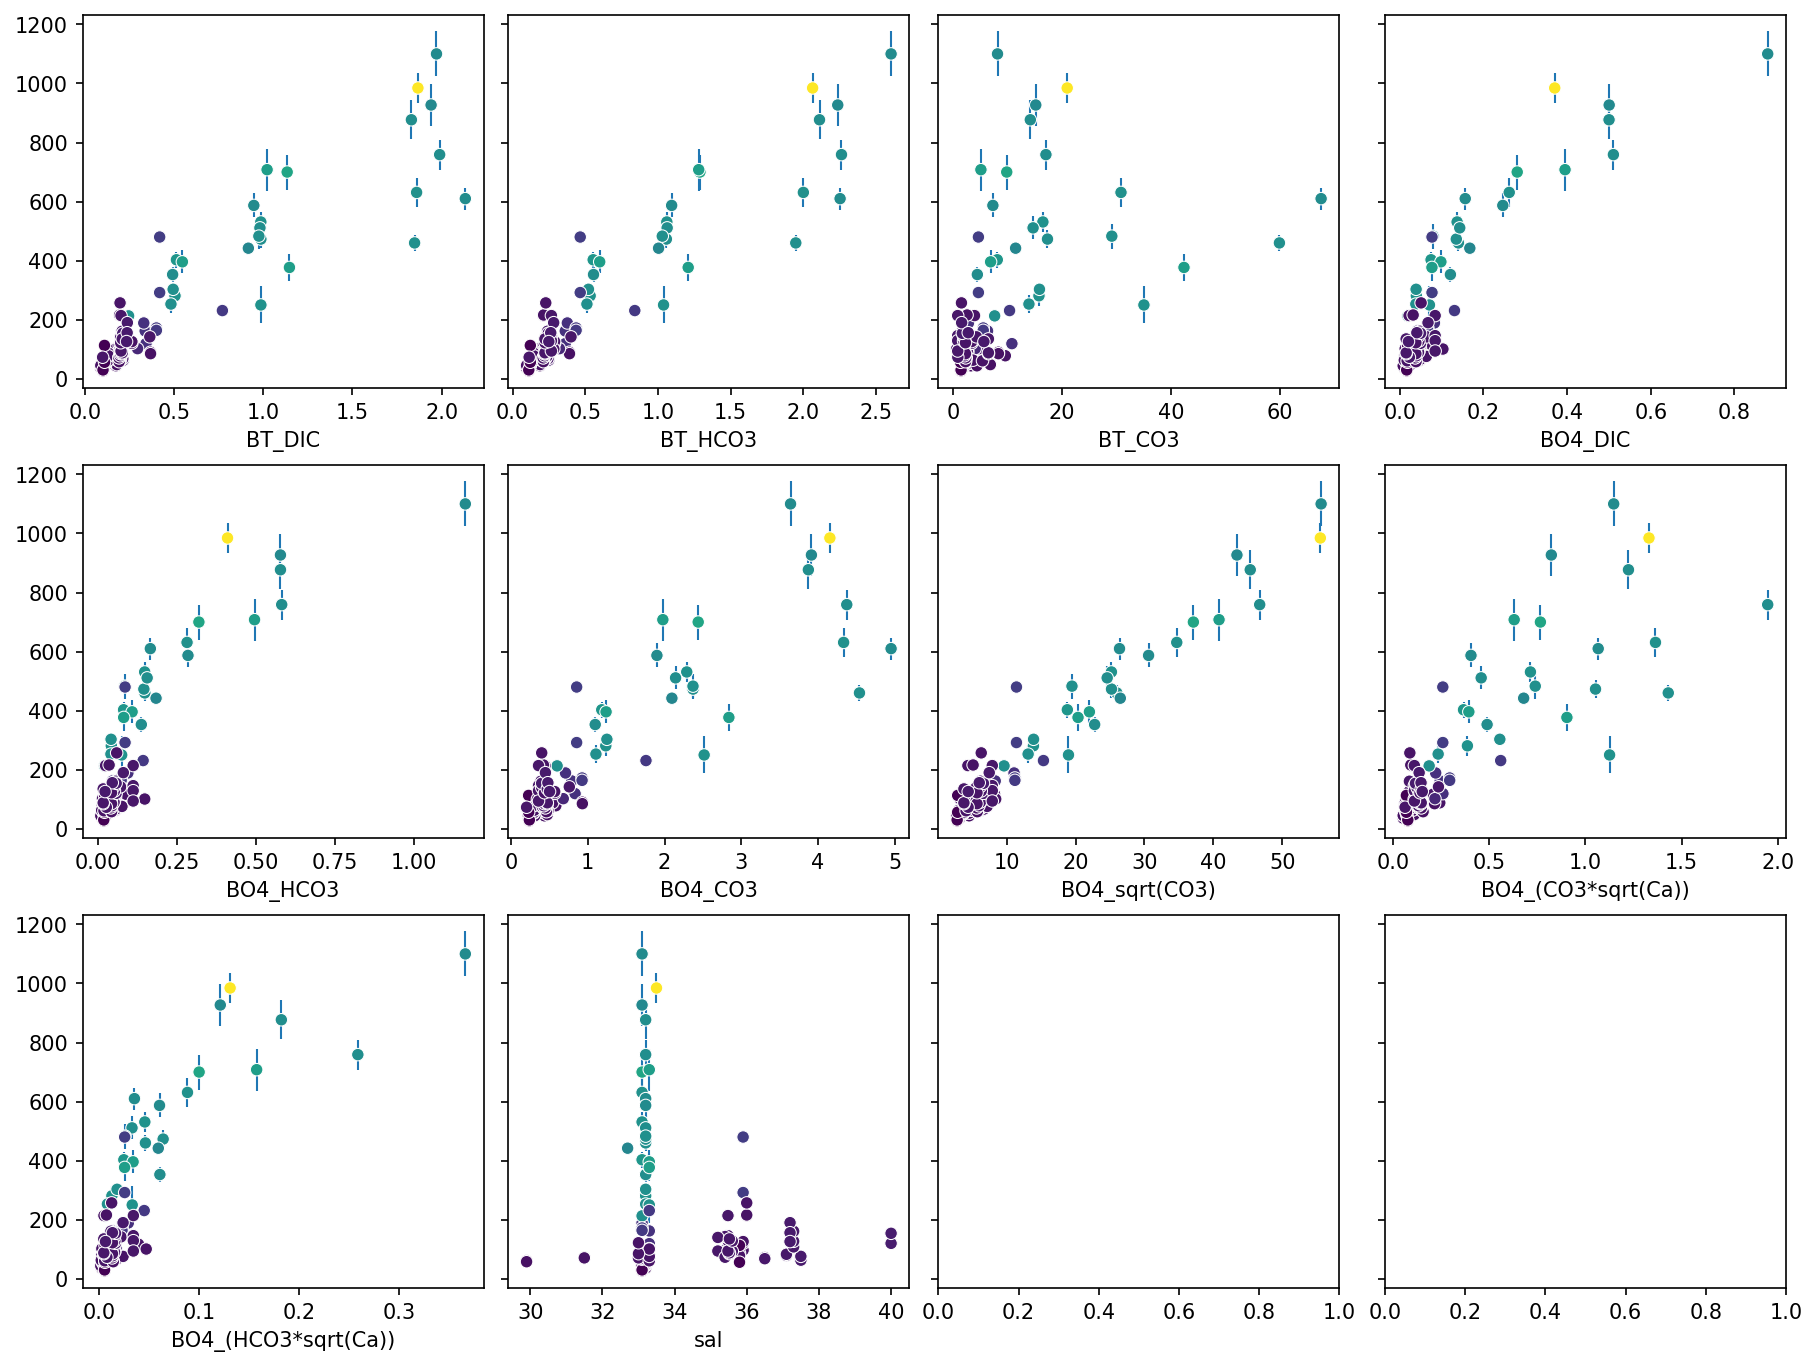

In [20]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

for k, ax in zip(denominators.keys(), axs.flat):
    ax.scatter(denominators[k], y, lw=0.5, edgecolor='w', c=dat.csys_mid.BT)
    ax.errorbar(denominators[k], y, y_err, zorder=-1, lw=0, elinewidth=1)
    ax.set_xlabel(k)

In [21]:
sw = cb.CBsys(TA=2300, pHtot=np.array([7.5, 8.5]))
sw.BO4 / np.sqrt(sw.CO3)

array([3.61004579, 8.94791627])

In [22]:
dat.Measured.who.unique()

array(['This Study', 'Haynes et al. (2017)', 'Haynes et al. (2019)',
       'Allen et al. (2011)', 'Allen et al. (2012)',
       'Henehan et al. (2015)'], dtype=object)

In [23]:
def plotline(x,y,ax,xn=None,alpha=0.3,**kwargs):
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    try:
        p, cov = np.polyfit(x, y, 1, cov=True)
        up = un.correlated_values(p, cov)
        if xn is None:
            xn = np.linspace(x.min(), x.max())
        yn = np.polyval(up, xn)
        line = ax.plot(xn, nom(yn), **kwargs)[0]
        ax.fill_between(xn, nom(yn)-err(yn), nom(yn)+err(yn), alpha=alpha*0.3, **kwargs)
        return r2_score(y, np.polyval(p, x))
    except ValueError:
        return np.nan
    
    

In [24]:
# define groups for plotting

ind0 = (dat.Measured.who == 'This Study')

inds = {
#     'Kate Orb.': ind0,
#     'Other Orb.': ~ind0 & (dat.Measured.Species == 'universa'),
    'Pink ruber': ~ind0 & (dat.Measured.Species == 'ruber') & (dat.Measured.Type == 'pink'),
#     'White ruber': ~ind0 & (dat.Measured.Species == 'ruber') & (dat.Measured.Type == 'white'),
#     'Sacc': ~ind0 & (dat.Measured.Species == 'sacculifer'),
#     'amphis': ~ind0 & (dat.Measured.Species == 'lessonii'),
}

# at 'normal' BT
binds = {k: v & (dat.csys_mid.BT < 500) for k, v in inds.items()}

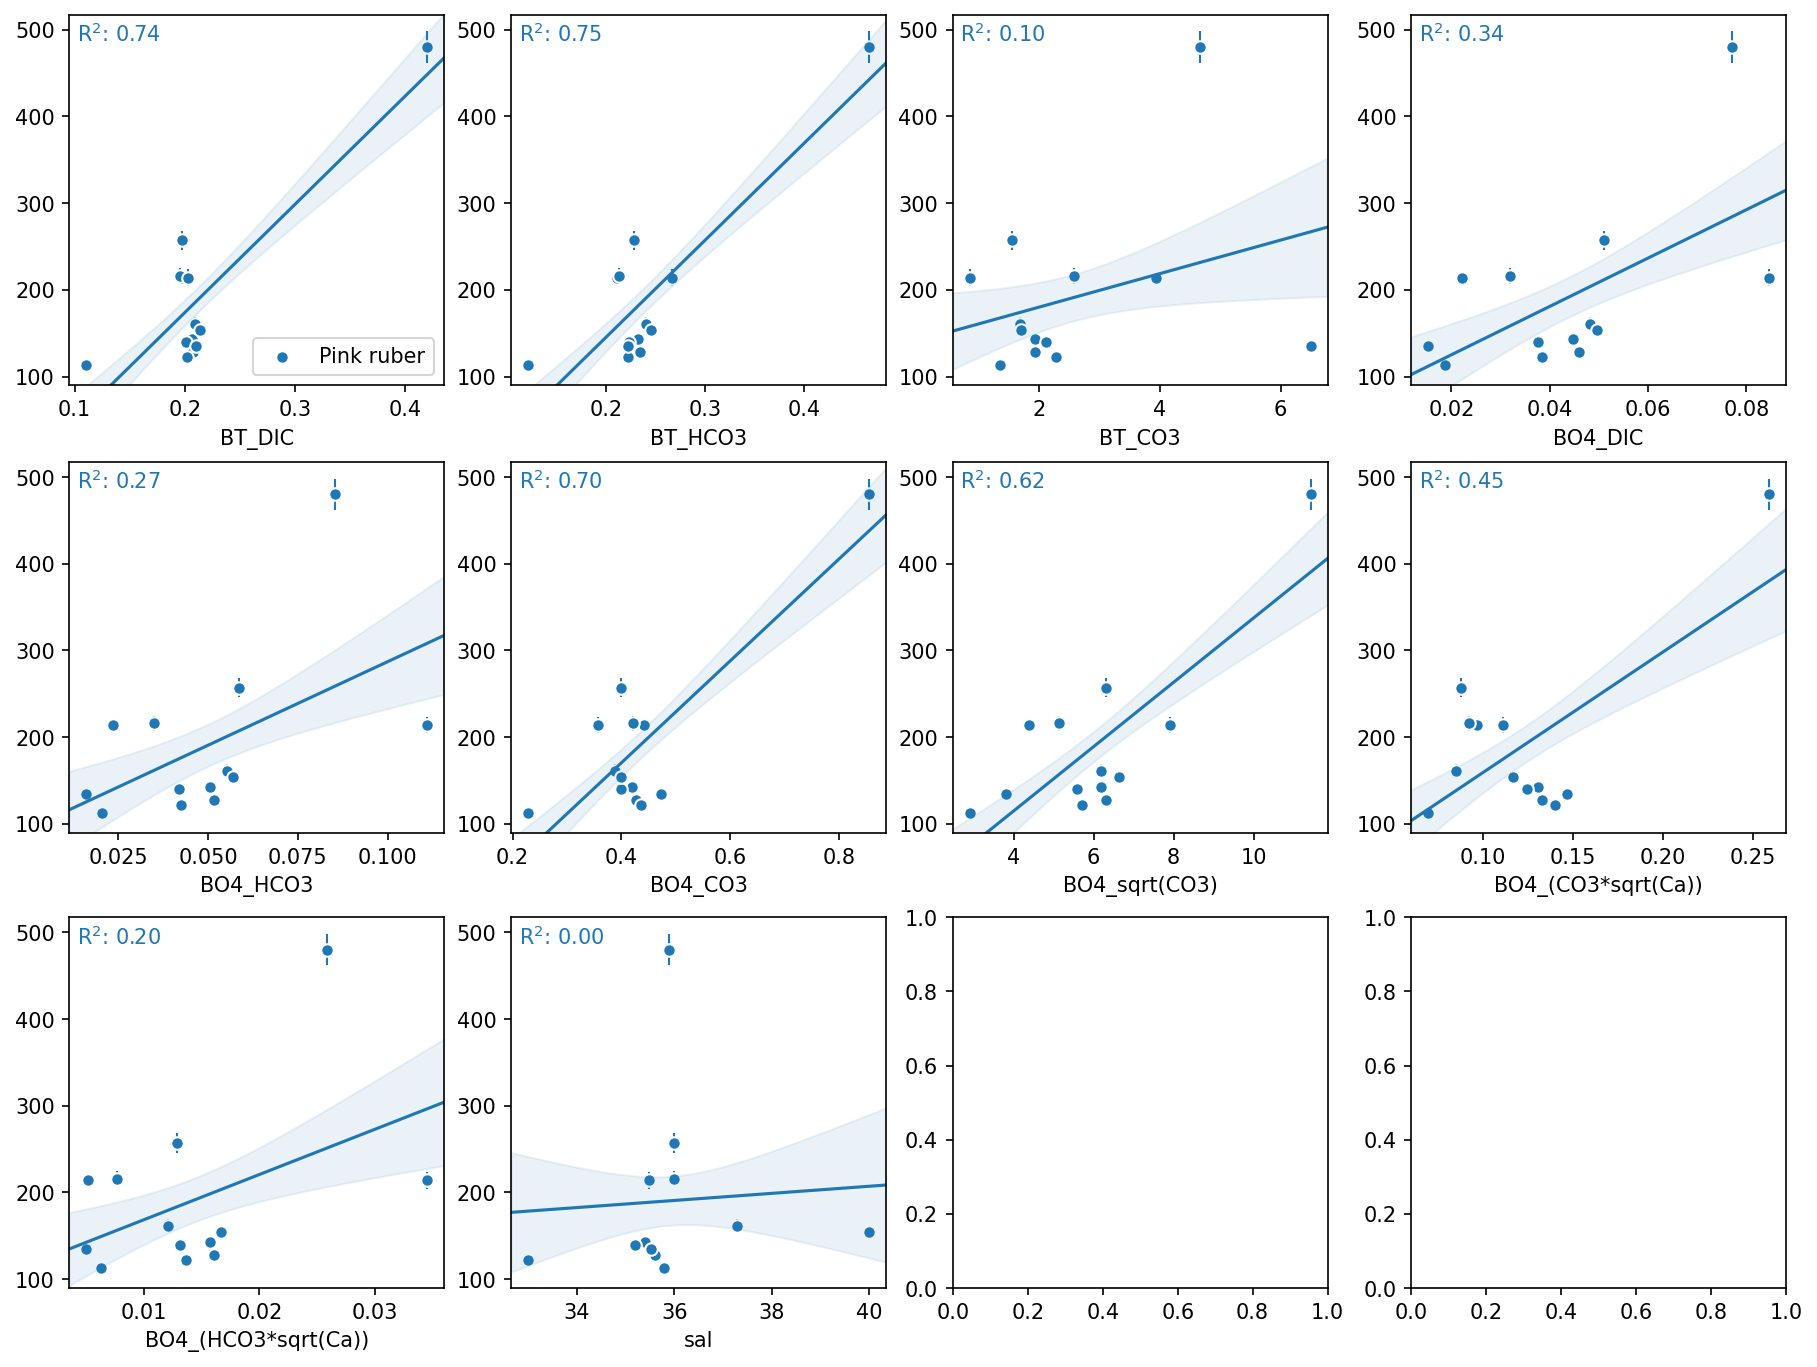

In [25]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

cs = {}
    
for k, ax in zip(denominators.keys(), axs.flat):
    for label, ind in inds.items():
        points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label)
        ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
        cs[label] = points.get_facecolor()[0]
      
    xn = np.linspace(*ax.get_xlim())
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    prepend = ''
    for label, ind in inds.items():
        r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label])
        ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
        prepend += '\n'
    ax.set_xlabel(k)

axs[0,0].legend(loc='lower right')


(10.0, 300.0)

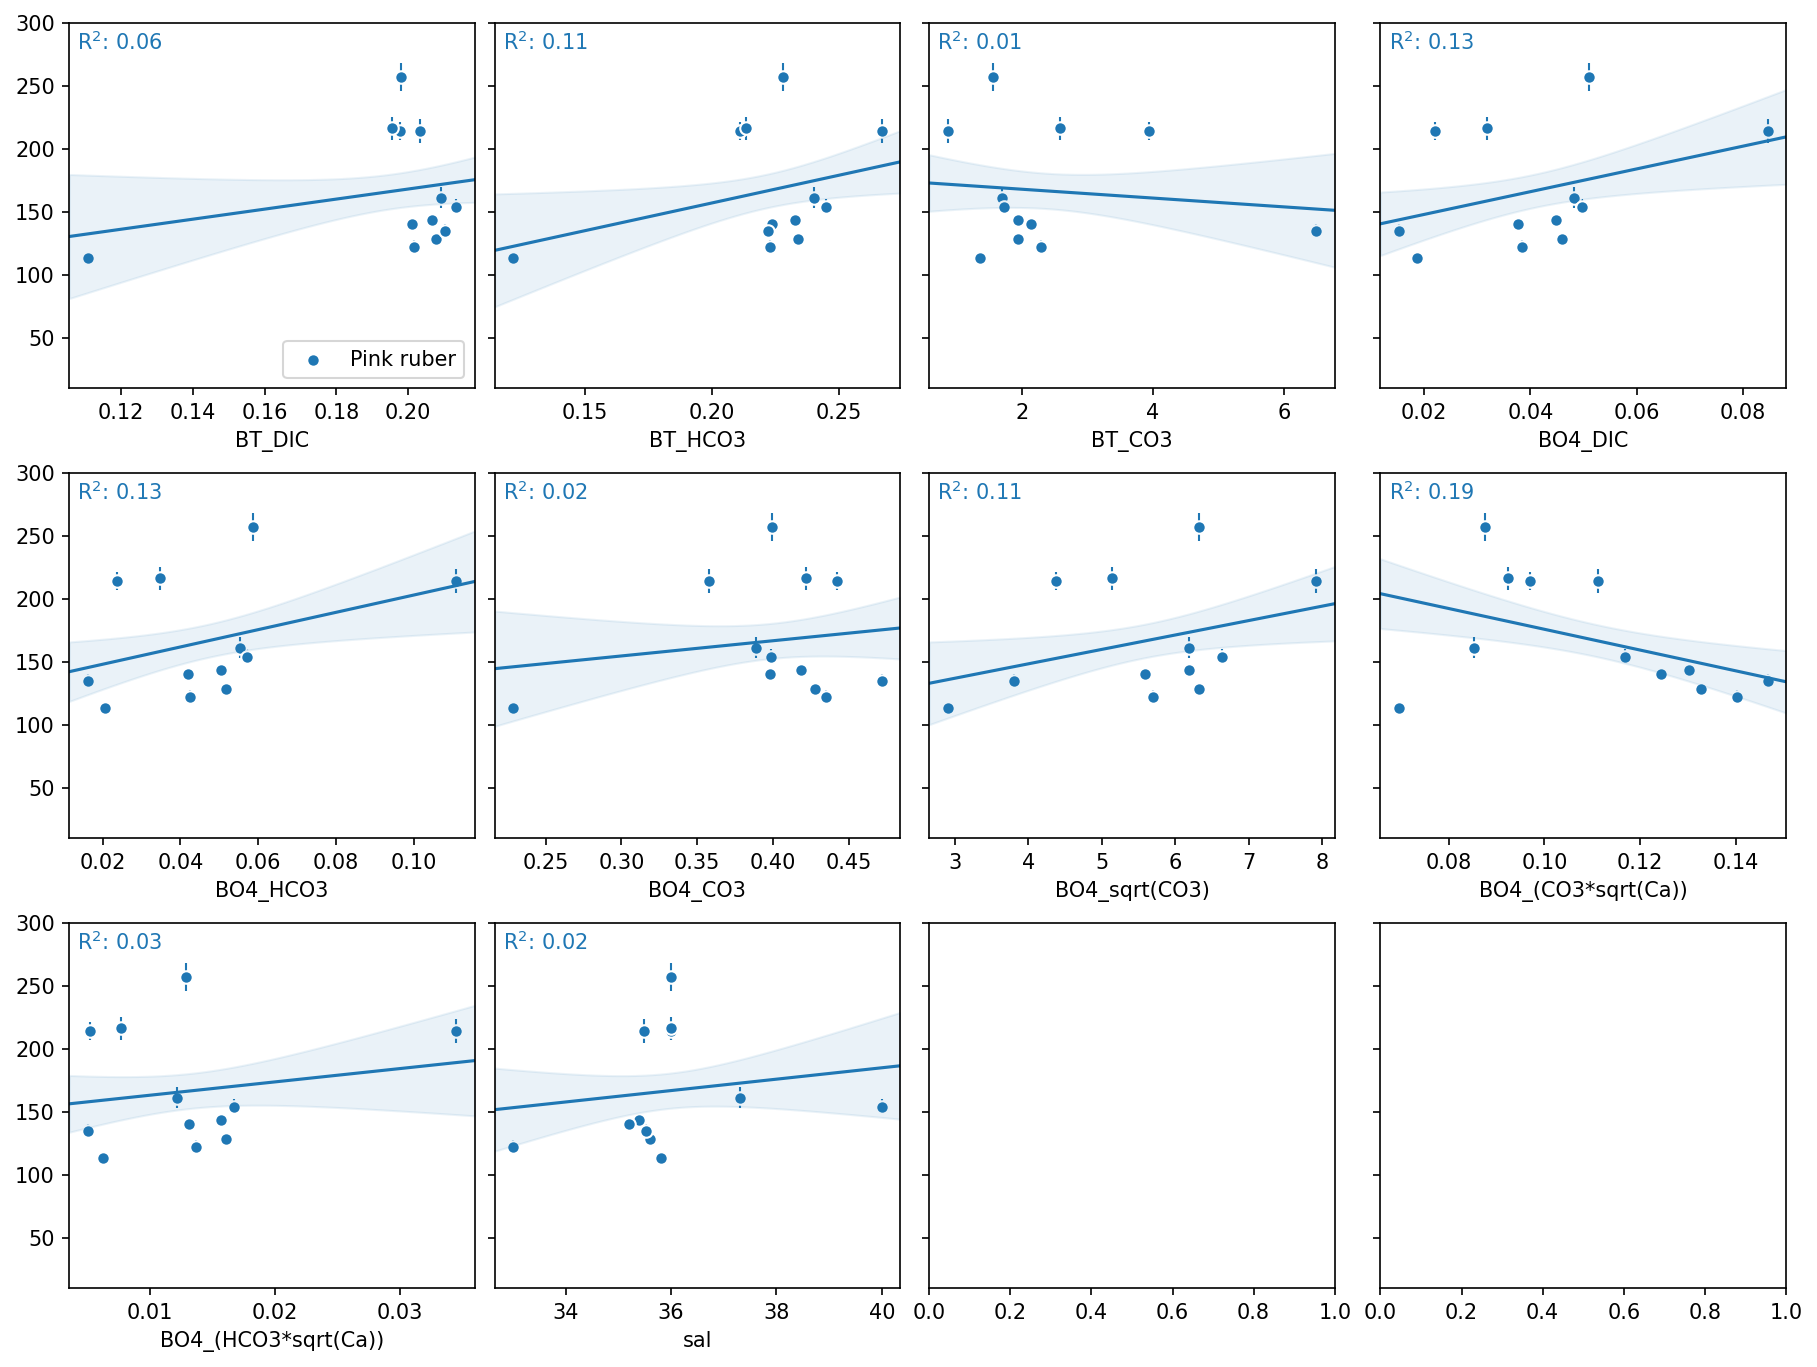

In [26]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

cs = {}
    
for k, ax in zip(denominators.keys(), axs.flat):
    for label, ind in binds.items():
        points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label)
        ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
        cs[label] = points.get_facecolor()[0]
      
    xn = np.linspace(*ax.get_xlim())
    ax.set_xlim(ax.get_xlim())
    prepend = ''
    for label, ind in binds.items():
        r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label])
        ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
        prepend += '\n'

    ax.set_xlabel(k)

axs[0,0].legend(loc='lower right')

axs[0,0].set_ylim(10, 300)

(10.0, 300.0)

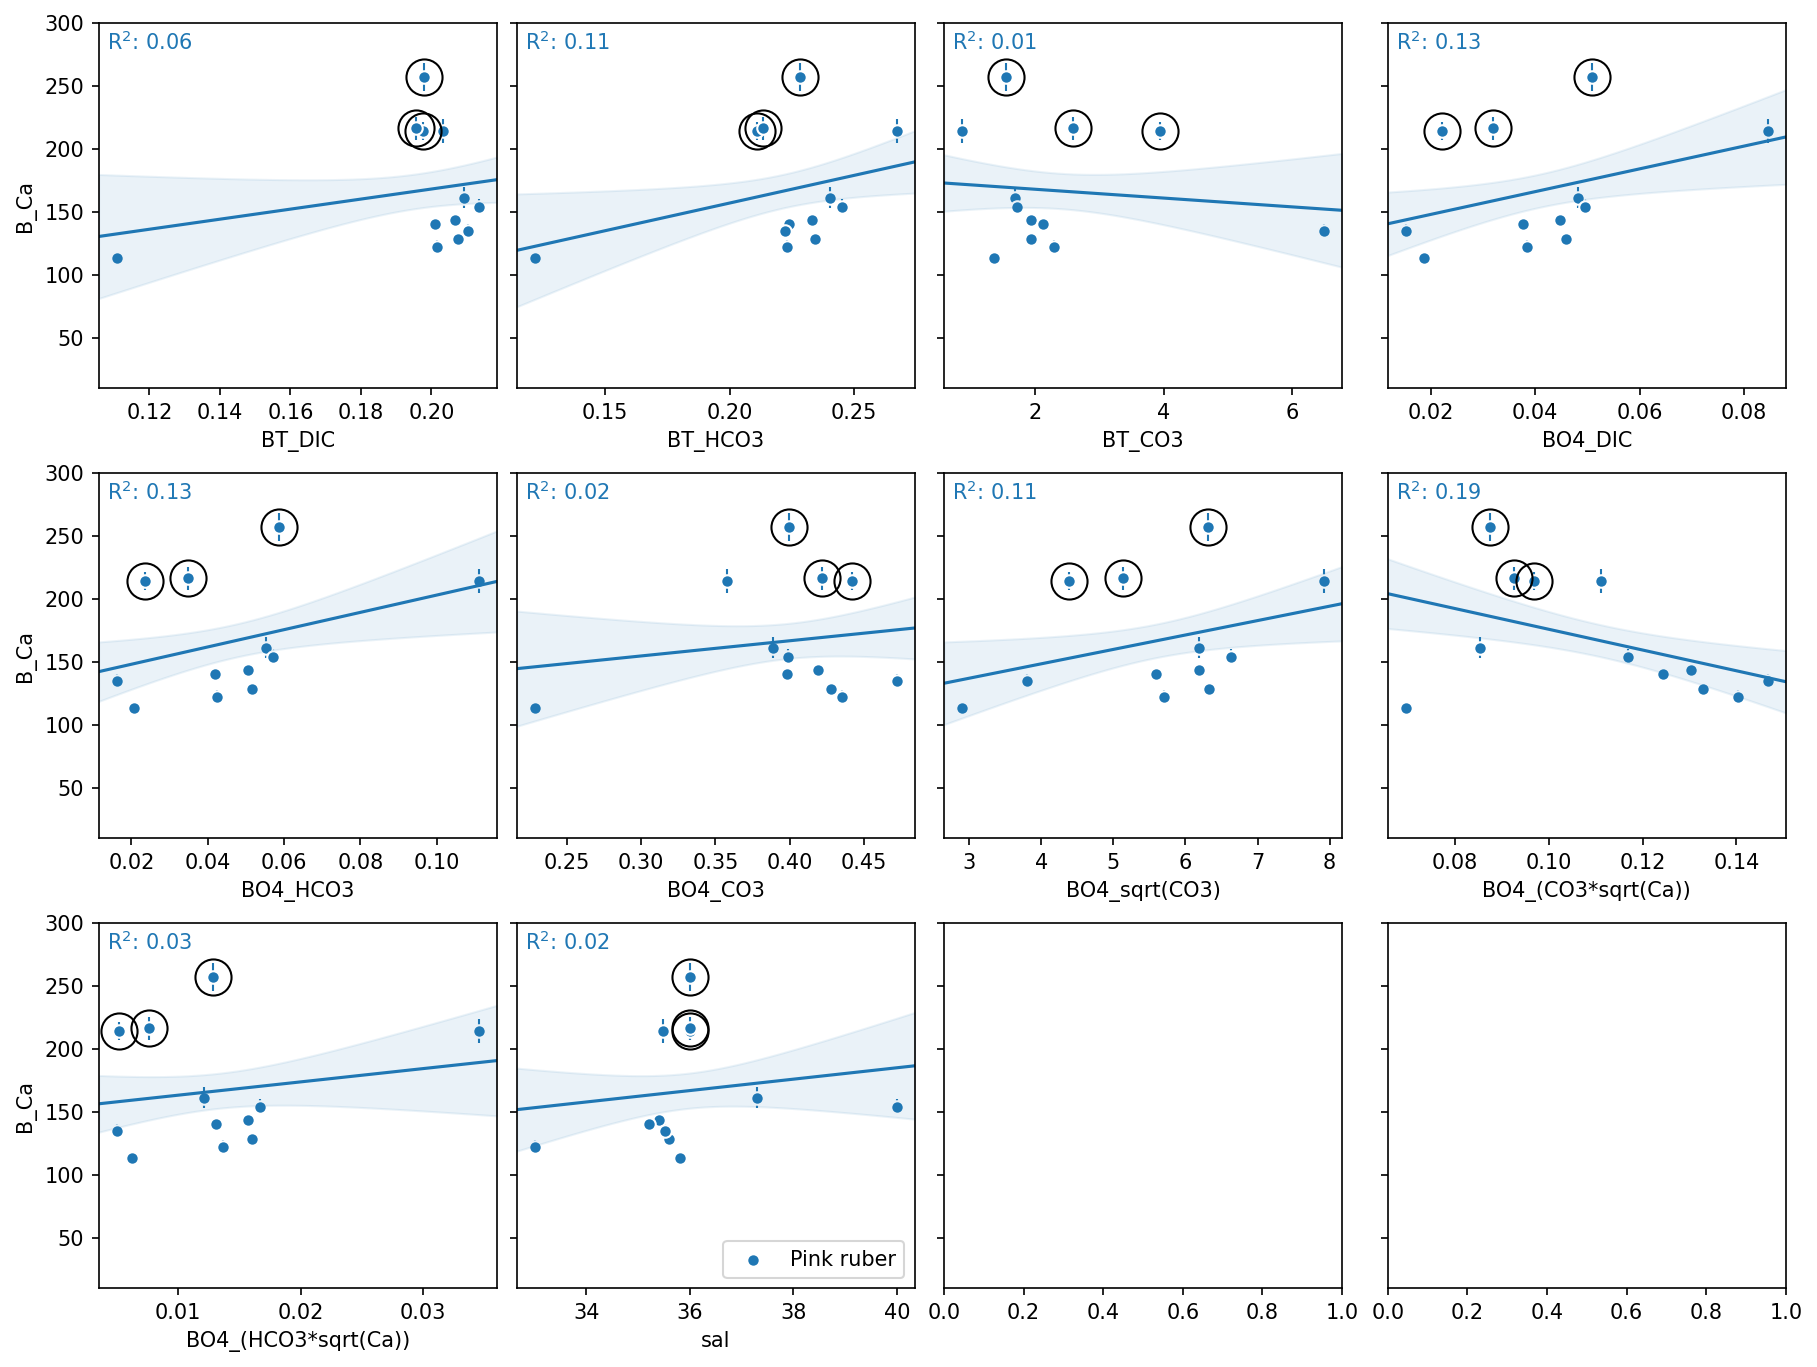

In [27]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

ind0 = (dat.Measured.who == 'This Study')

inds = {
    'Kate Orb.': ind0,
    'Other Orb.': ~ind0 & (dat.Measured.Species == 'universa'),
    'Pink ruber': ~ind0 & (dat.Measured.Species == 'ruber') & (dat.Measured.Type == 'pink'),
    'White ruber': ~ind0 & (dat.Measured.Species == 'ruber') & (dat.Measured.Type == 'white'),
    'Sacc': ~ind0 & (dat.Measured.Species == 'sacculifer'),
#     'amphis': ~ind0 & (dat.Measured.Species == 'lessonii'),
}

# hind = (dat.Measured.who == 'Haynes et al. (2019)') & inds['punk ruberz'] & (KBs['BO4_sqrt(CO3)'] > 37)
hind = [74, 75, 76]

cs = {}
    
for k, ax in zip(denominators.keys(), axs.flat):
    for label, ind in binds.items():
        points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label)
        ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
        cs[label] = points.get_facecolor()[0]
      
    xn = np.linspace(*ax.get_xlim())
    ax.set_xlim(ax.get_xlim())
    prepend = ''
    for label, ind in binds.items():
        r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label])
        ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
        prepend += '\n'
    
    ax.scatter(denominators[k][hind], y[hind], s=300, facecolor=(0,0,0,0), edgecolor='k', lw=1)
    
    ax.set_xlabel(k)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('B_Ca')

axs[2,1].legend(loc='lower right')

axs[0,0].set_ylim(10, 300)

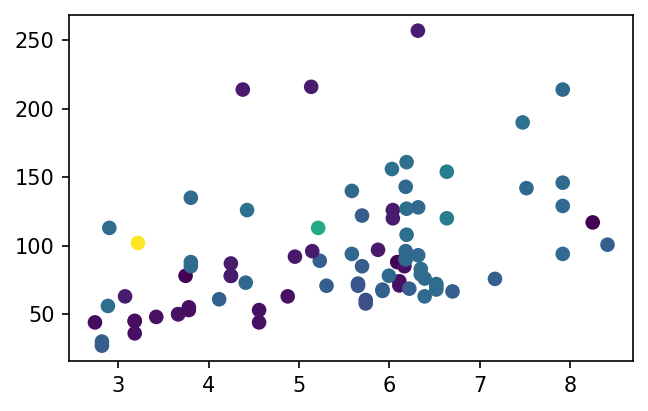

In [28]:
plt.scatter(denominators['BO4_sqrt(CO3)'][dat.csys_mid.BT < 500], y[dat.csys_mid.BT < 500], c=dat.loc[dat.csys_mid.BT < 500, ('Measured', '[Mg]sw')])

In [29]:
dat.loc[dat.csys_mid.BT < 500, ('Measured', '[Ca]sw')].max()

27.22

In [30]:
dat.loc[hind]

Measured                                                               \
       Year  Temp Salinity [Mg]sw [Ca]sw [B]sw Mg/Casw Mg/Caf Mg/Caf_err   
74     2015  26.0     36.0   31.0   20.8   387    1.49    NaN        NaN   
75     2015  26.0     36.0   30.8   20.8   383    1.48    NaN        NaN   
76     2015  26.0     36.0   31.1   20.8   388    1.50    NaN        NaN   

            ... Uncertainties                                                \
   B/CaCAM  ... estimated_std reported_std        std         se       ci95   
74     NaN  ...     36.185421          7.0  36.185421   6.963888  14.314476   
75     NaN  ...     36.523602          7.0  36.523602   8.858275  18.778704   
76     NaN  ...     43.456323          8.5  43.456323  11.220374  24.065310   

                        Measured                      csys_mid            
         ci68                 KB            KB_HCO3    del_CO3    BT_DIC  
74   7.060290          1082+/-35          1014+/-33  20.359296  0.197697  
75   9.091577  (1.10+/-0.05)e+03  (1.01+/-0.04)e+03  20.337664  0.195502  
76  11.568802  (1.30+/-0.06)e+03  (1.13+/-0.05)e+03  20.370112  0.197911  

[3 rows x 84 columns]

In [31]:
dat.loc[hind].to_csv('data/Haynes_question.csv')

## Resi plot for BO4/sqrt(CO3)

In [32]:
load.b_data()

csys_var = 'csys_mid'

extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     (csys_var, 'Omega'),
    (csys_var, 'BO4'),
    (csys_var, 'BT'),
    (csys_var, 'CO3'),
    (csys_var, 'pHtot'),
    (csys_var, 'DIC'),
#     (csys_var, 'del_CO3'),
]

ratio = 'BO4_sqrt(CO3)'
print(f'KB Denominator: {ratio}')
candidates = dat.loc[:, extras]
y0 = dat.loc[:, ('Measured', 'B/Caf')]
yu = y0 / denominators[ratio]
y = nom(yu)
w = 1 / err(yu)**2
brute = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, scale_data=True, Scaler=StandardScaler)
_ = brute.evaluate_polynomials()

KB Denominator: BO4_sqrt(CO3)


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

In [33]:
dat.loc[(dat.Measured.who == 'Haynes et al. (2019)') & (dat.Measured.Species == 'ruber')]

Measured                                                                \
       Year   Temp Salinity [Mg]sw [Ca]sw [B]sw Mg/Casw Mg/Caf Mg/Caf_err   
74     2015  26.00     36.0   31.0   20.8   387    1.49    NaN        NaN   
75     2015  26.00     36.0   30.8   20.8   383    1.48    NaN        NaN   
76     2015  26.00     36.0   31.1   20.8   388    1.50    NaN        NaN   
77     2015  25.87     37.3   55.2   20.8   428    2.65    NaN        NaN   
78     2015  26.05     35.8   54.2   10.8   218    5.02    NaN        NaN   
79     2015  26.05     35.9   54.7   10.9   833    5.02    NaN        NaN   

            ... Uncertainties                                                \
   B/CaCAM  ... estimated_std reported_std        std         se       ci95   
74     NaN  ...     36.185421          7.0  36.185421   6.963888  14.314476   
75     NaN  ...     36.523602          7.0  36.523602   8.858275  18.778704   
76     NaN  ...     43.456323          8.5  43.456323  11.220374  24.065310   
77     NaN  ...     27.223611          5.5  27.223611   8.208228  18.289071   
78     NaN  ...     19.107255          3.5  19.107255   3.821451   7.887087   
79     NaN  ...     81.163561         16.0  81.163561  18.148724  37.985716   

                        Measured                      csys_mid            
         ci68                 KB            KB_HCO3    del_CO3    BT_DIC  
74   7.060290          1082+/-35          1014+/-33  20.359296  0.197697  
75   9.091577  (1.10+/-0.05)e+03  (1.01+/-0.04)e+03  20.337664  0.195502  
76  11.568802  (1.30+/-0.06)e+03  (1.13+/-0.05)e+03  20.370112  0.197911  
77   8.589275    (7.7+/-0.4)e+02           670+/-34  24.086496  0.209127  
78   3.880653          1020+/-35           928+/-31  41.090337  0.110756  
79  18.532976  (1.14+/-0.04)e+03  (1.03+/-0.04)e+03  40.991367  0.419893  

[6 rows x 84 columns]

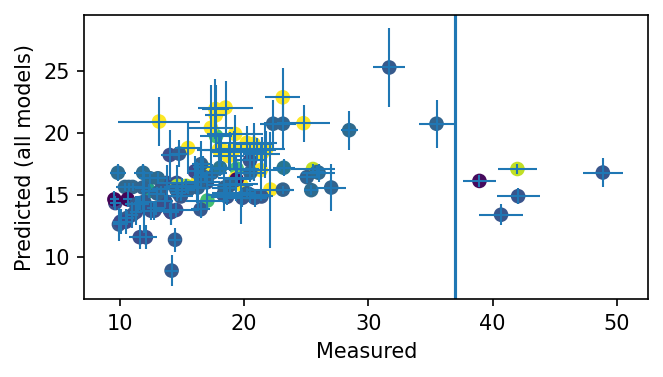

In [34]:
brute.plot_obs_vs_pred(c=dat.Measured['[B]sw'], vmin=200, vmax=900)
plt.axvline(37)

In [35]:
dat.loc[KBs['BO4_sqrt(CO3)'] > 37, ('Measured', 'Species')]

74    ruber
75    ruber
76    ruber
78    ruber
79    ruber
Name: (Measured, Species), dtype: object

## If going full empiribro, should expand to coretops and etc.

Wich means...

- Yu
- Hoenisch
- Rae
- Henehan
- Foster

In [36]:
ct = pd.read_csv('data/coretops/coretops_compiled.csv', header=[0,1])

In [37]:
ct_denominators = {}
ct_KBs = {}
y = ct.loc[:, ('measured', 'B/Ca')]
for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        ratio = f'{b}_{c}'
        ct_denominators[ratio] = (ct.loc[:, ('calculated', b)] / ct.loc[:, ('calculated', c)])
        ct_KBs[ratio] = y / ct_denominators[ratio]

ratio = 'BO4_sqrt(CO3)'
ct_denominators[ratio] = (ct.loc[:, ('calculated', 'BO4')] / ct.loc[:, ('calculated', 'CO3')]**0.5)
ct_KBs[ratio] = y / ct_denominators[ratio]

# Andy logic
ratio = 'BO4_(CO3*sqrt(Ca))'
ct_denominators[ratio] = (ct.loc[:, ('calculated', 'BO4')] / (ct.loc[:, ('calculated', 'CO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
ct_KBs[ratio] = y / ct_denominators[ratio]

ratio = 'BO4_(HCO3*sqrt(Ca))'
ct_denominators[ratio] = (ct.loc[:, ('calculated', 'BO4')] / (ct.loc[:, ('calculated', 'HCO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
ct_KBs[ratio] = y / denominators[ratio]

ct_denominators['sal'] = ct.loc[:, ('calculated', 'S_in')]

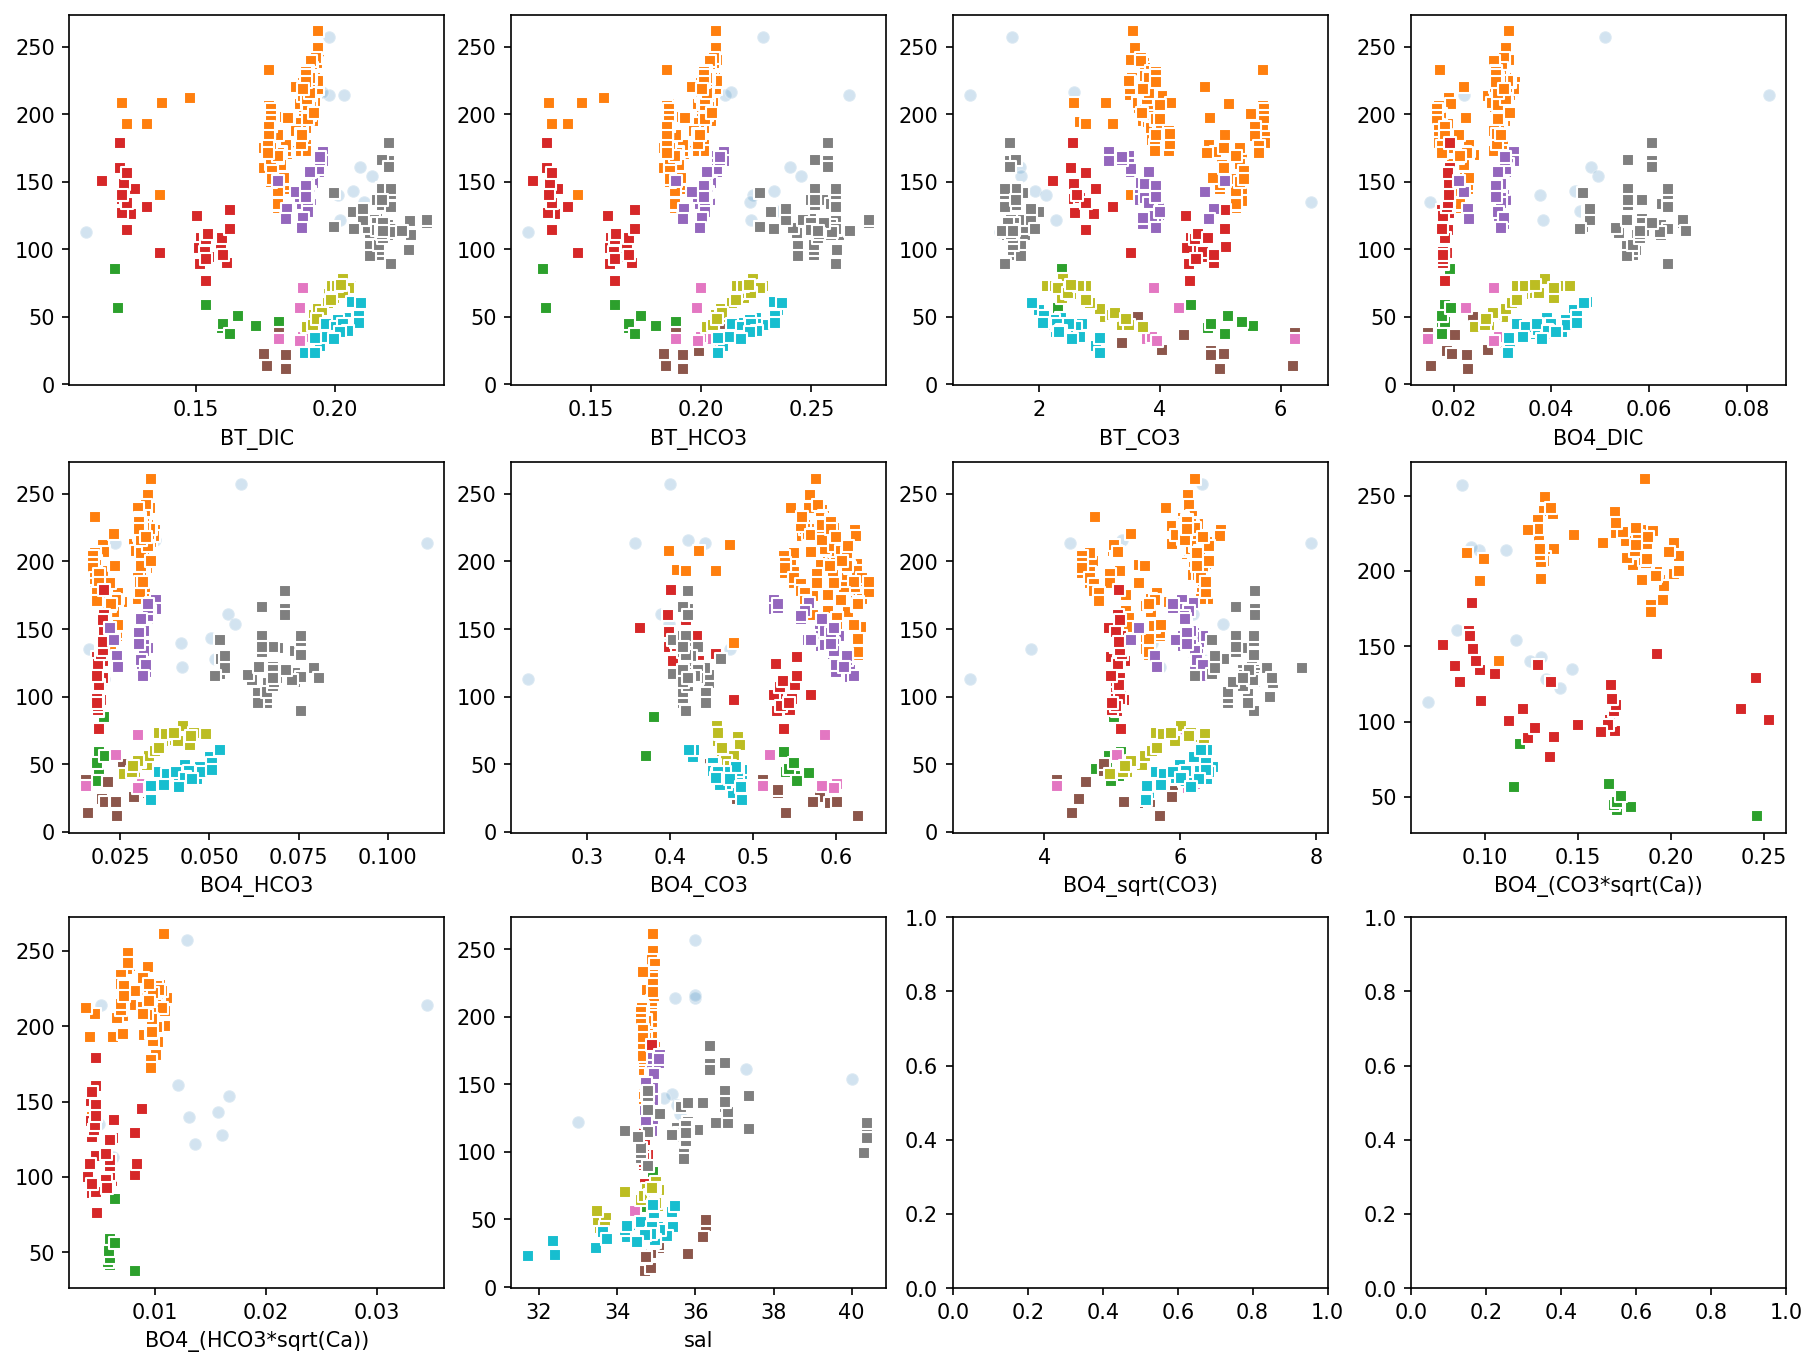

In [38]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

cs = {}

k = 'BO4_sqrt(CO3)'

for k, ax in zip(denominators.keys(), axs.flat):
    for label, ind in binds.items():
        points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.2)
    #     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
        cs[label] = points.get_facecolor()[0]

#     xn = np.linspace(*ax.get_xlim())
#     ax.set_xlim(ax.get_xlim())
#     prepend = ''
#     for label, ind in inds.items():
#         r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.1)
#         ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
#         prepend += '\n'

    ax.set_xlabel(k)

    for s in ct.metadata.species.unique():
        ind = ct.metadata.species == s
        ax.scatter(ct_denominators[k][ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
# ax.legend(bbox_to_anchor=(1, 0., 0, 1))

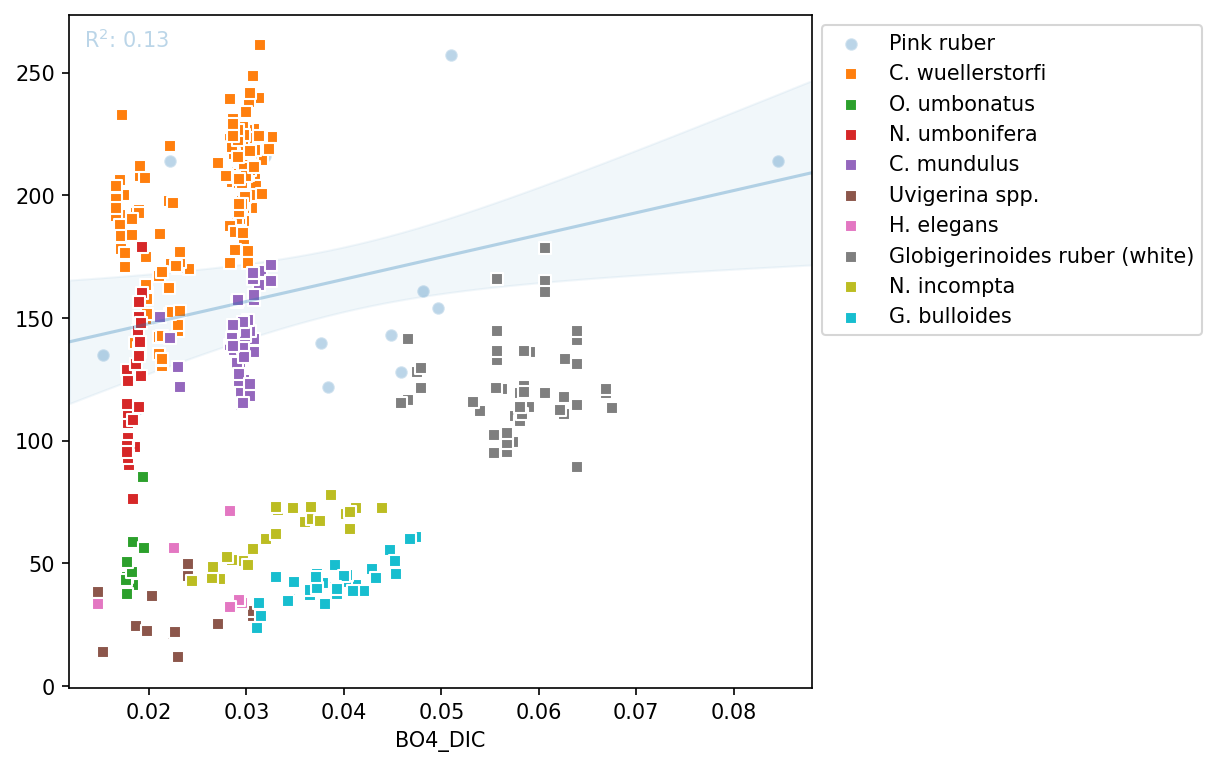

In [39]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

cs = {}

k = 'BO4_DIC'
for label, ind in binds.items():
    points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.3)
#     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
    cs[label] = points.get_facecolor()[0]

xn = np.linspace(*ax.get_xlim())
ax.set_xlim(ax.get_xlim())
prepend = ''
for label, ind in binds.items():
    r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.2)
    ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
    prepend += '\n'

ax.set_xlabel(k)

for s in ct.metadata.species.unique():
    ind = ct.metadata.species == s
    plt.scatter(ct.calculated.BO4[ind] / ct.calculated.DIC[ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
ax.legend(bbox_to_anchor=(1, 0., 0, 1))

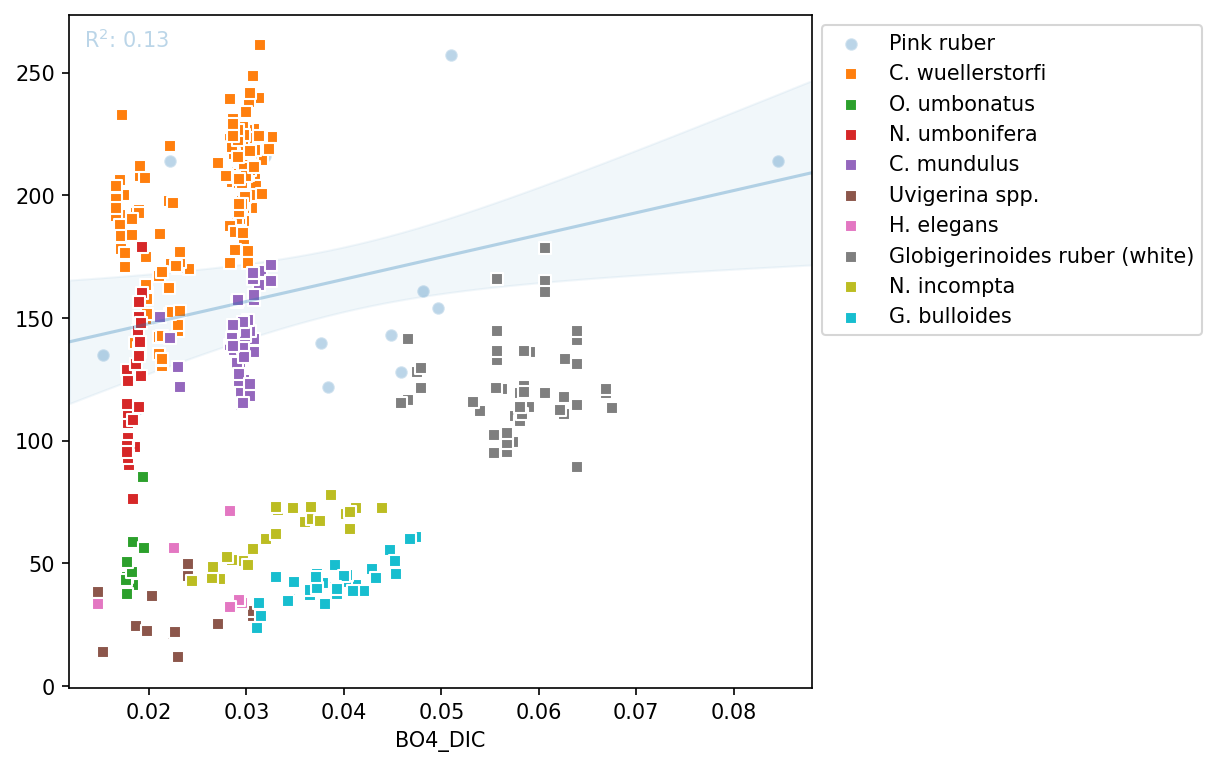

In [40]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

cs = {}

k = 'BO4_DIC'
for label, ind in binds.items():
    points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.3)
#     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
    cs[label] = points.get_facecolor()[0]

xn = np.linspace(*ax.get_xlim())
ax.set_xlim(ax.get_xlim())
prepend = ''
for label, ind in binds.items():
    r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.2)
    ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
    prepend += '\n'

ax.set_xlabel(k)

for s in ct.metadata.species.unique():
    ind = ct.metadata.species == s
    plt.scatter(ct.calculated.BO4[ind] / ct.calculated.DIC[ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
ax.legend(bbox_to_anchor=(1, 0., 0, 1))

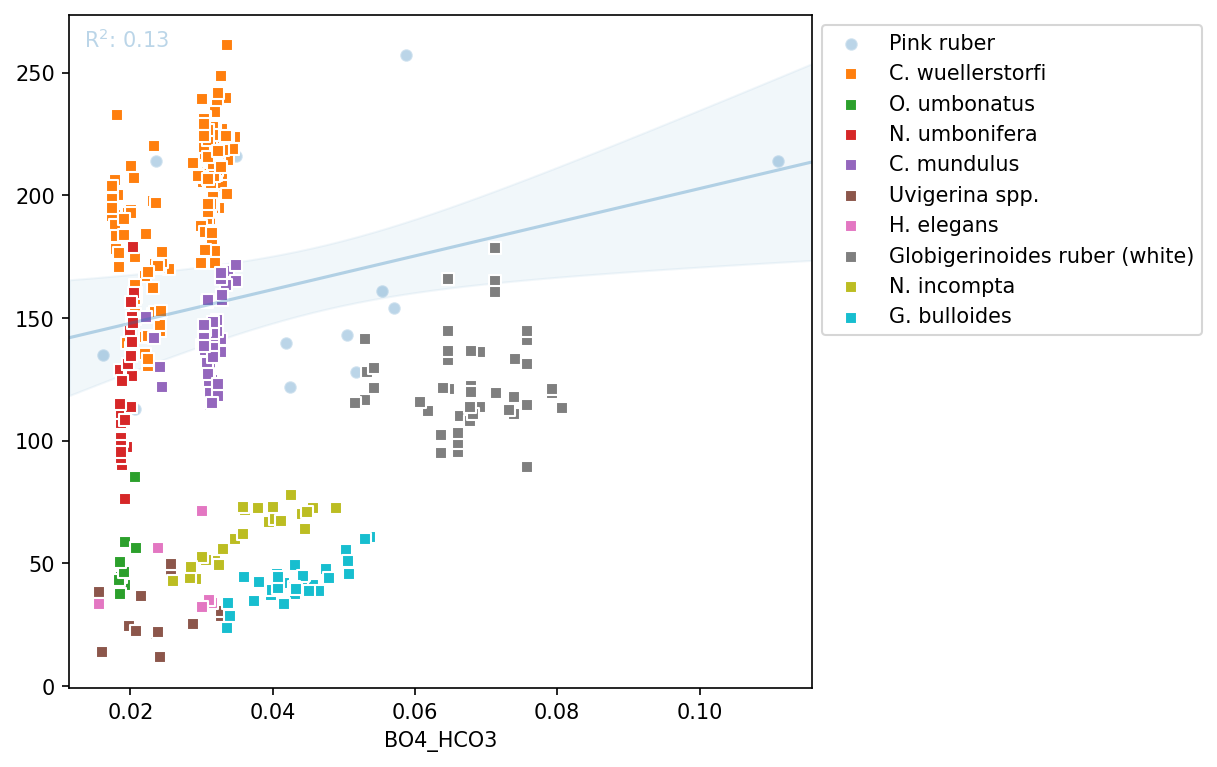

In [41]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

cs = {}

k = 'BO4_HCO3'
for label, ind in binds.items():
    points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.3)
#     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
    cs[label] = points.get_facecolor()[0]

xn = np.linspace(*ax.get_xlim())
ax.set_xlim(ax.get_xlim())
prepend = ''
for label, ind in binds.items():
    r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.2)
    ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
    prepend += '\n'

ax.set_xlabel(k)

for s in ct.metadata.species.unique():
    ind = ct.metadata.species == s
    plt.scatter(ct.calculated.BO4[ind] / ct.calculated.HCO3[ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
ax.legend(bbox_to_anchor=(1, 0., 0, 1))

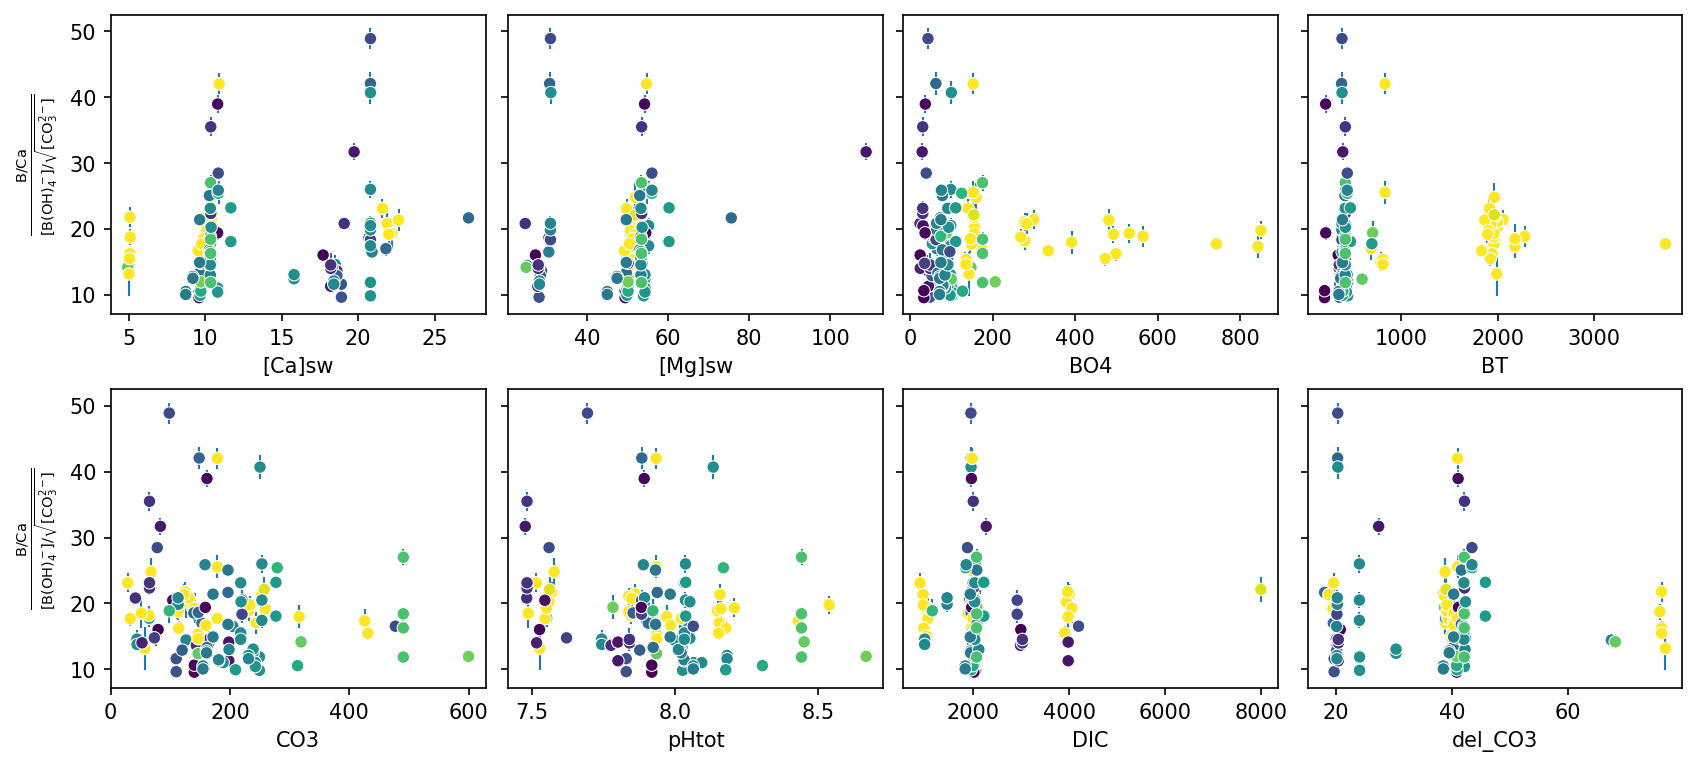

In [42]:
# residuals against partitioning

K = KBs['BO4_sqrt(CO3)']

extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     ('csys_mid', 'Omega'),
    ('csys_mid', 'BO4'),
    ('csys_mid', 'BT'),
    ('csys_mid', 'CO3'),
    ('csys_mid', 'pHtot'),
    ('csys_mid', 'DIC'),
    ('csys_mid', 'del_CO3'),
]

ncol = 4
nrow = len(extras) // ncol
if len(extras) % ncol > 0:
    nrow += 1
    
fig, axs = plt.subplots(nrow, ncol, figsize=[ncol * 2.8, nrow * 2.5], constrained_layout=True, sharey=True)

for e, ax in zip(extras, axs.flat):
    ax.scatter(dat.loc[:, e], nom(K), lw=0.5, edgecolor='w', c=denominators['BO4_sqrt(CO3)'], vmax=10)
    ax.errorbar(dat.loc[:, e], nom(K), err(K), lw=0, elinewidth=1, zorder=-1)
    ax.set_xlabel(e[-1])
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r'$\frac{B/Ca}{[B(OH)_4^-]/ \sqrt{[CO_3^{2-}]}}$')

## Calculate Best Fits for all partitioning

In [44]:
csys_var = 'csys_mid'

extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     (csys_var, 'Omega'),
    (csys_var, 'BO4'),
    (csys_var, 'BT'),
    (csys_var, 'CO3'),
    (csys_var, 'pHtot'),
    (csys_var, 'DIC'),
#     (csys_var, 'del_CO3'),
]

brutes = {}

exclude_denominator = False
exclude_numerator = False

y0 = dat.loc[:, ('Measured', 'B/Caf')]

for b in ['BT', 'BO4']:
    iextras = extras
    if exclude_numerator:
        iextras = [e for e in iextras if e[1] != b]
    for c in ['DIC', 'HCO3', 'CO3']:
        if b == 'BT' and c == 'CO3':
            continue
        if exclude_denominator:
            iextras = [e for e in iextras if e[1] != c]
        ratio = f'{b}_{c}'
        print(f'KB Denominator: {ratio}')
        candidates = dat.loc[:, iextras]
        yu = y0 / denominators[ratio]
        y = nom(yu)
        w = 1 / err(yu)**2

        brutes[ratio] = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, Scaler=StandardScaler)
        _ = brutes[ratio].evaluate_polynomials()
    
# bo4 / sqrt(co3)
ratio = 'BO4_sqrt(CO3)'
b = 'BO4'
c = 'CO3'
iextras = extras
if exclude_denominator:
    iextras = [e for e in iextras if e[1] != c]
if exclude_numerator:
    iextras = [e for e in iextras if e[1] != b]
print(f'KB Denominator: {ratio}')
candidates = dat.loc[:, iextras]
yu = y0 / denominators[ratio]
y = nom(yu)
w = 1 / err(yu)**2
brutes[ratio] = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, scale_data=True, Scaler=StandardScaler)
_ = brutes[ratio].evaluate_polynomials()

KB Denominator: BT_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BT_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_CO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_sqrt(CO3)


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

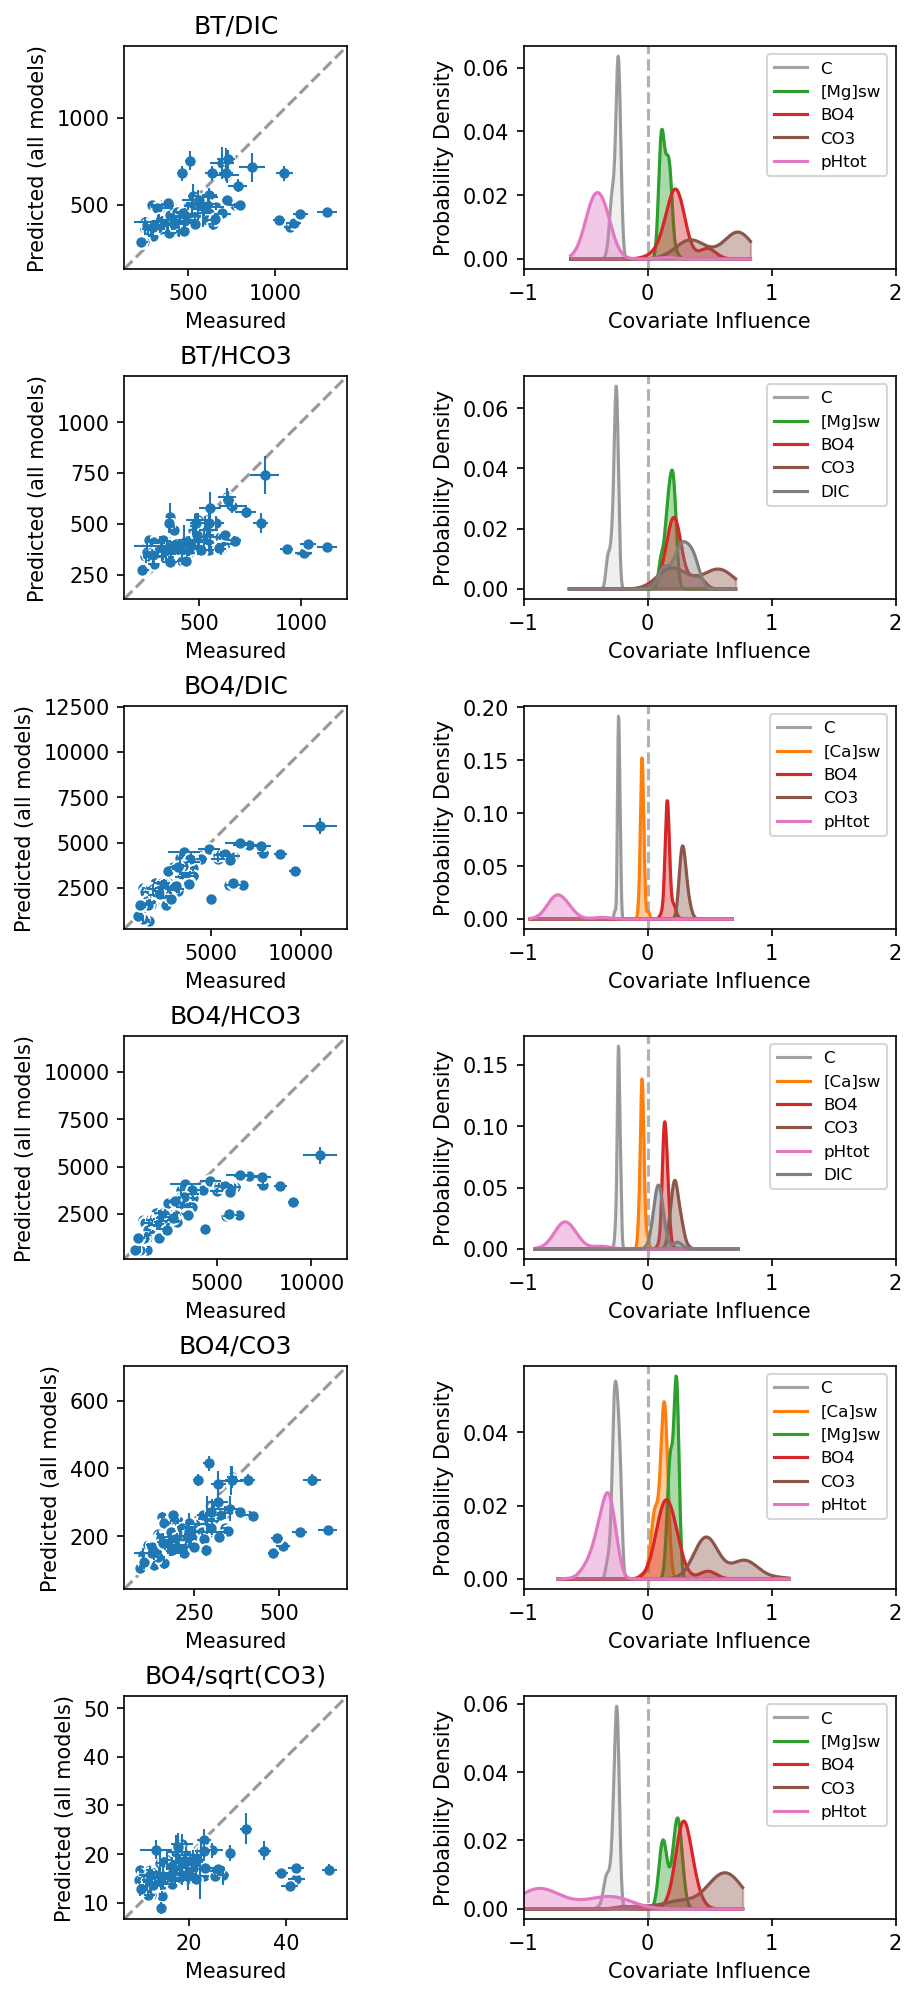

In [45]:
fig, axs = plt.subplots(len(brutes), 2, figsize=[6, 2.2 * len(brutes)], constrained_layout=True)

p_level = 0.05

for i, k in enumerate(brutes.keys()):
    pax, dax = axs[i]
    b = brutes[k]

    
    b.plot_obs_vs_pred(ax=pax, lw=1, edgecolor='w')
    lim = [min(pax.get_xlim()[0], pax.get_ylim()[0]),
           max(pax.get_xlim()[1], pax.get_ylim()[1])]
    pax.set_xlim(lim)
    pax.set_ylim(lim)
    pax.plot(lim, lim, ls='dashed', color=(0,0,0,0.4), zorder=-1)
    
    b.plot_param_dists(ax=dax, filter_zeros=p_level)
    dax.legend(fontsize=8)
    dax.set_xlim(-1, 2)
    
    pax.set_title(k.replace('_','/'))

Add panels to right showing influence of each identified significant effect.

In [46]:
# aggregate fits
df = []
for r, b in brutes.items():
    tdf = b.modelfits
    tdf['r'] = r
    df.append(tdf)
         
df = pd.concat(df)

# calculate global metrics
df.loc[:, ('metrics', 'BF_max')] = df.loc[:, ('metrics', 'BF0')] / df.loc[:, ('metrics', 'BF0')].max()
df.loc[:, ('metrics', 'K')] = 1 / df.loc[:, ('metrics', 'BF_max')]
df.loc[:, ('metrics', 'evidence_against')] = None

df.sort_values(('metrics', 'K'), inplace=True)
df.reset_index(drop=True, inplace=True)

In [47]:
brutes['BO4_DIC'].varnames

['[Ca]sw', '[Mg]sw', 'BO4', 'BT', 'CO3', 'pHtot', 'DIC']

In [48]:
df.head(10)

coefs                                                            \
          C      X0^1    X1^1      X2^1      X3^1      X4^1      X5^1   
0 -0.233644       NaN     NaN  0.142814       NaN  0.217124 -0.663575   
1 -0.230492       NaN     NaN       NaN  0.148209  0.190820 -0.578568   
2 -0.233032 -0.043733     NaN  0.147506       NaN  0.236490 -0.702021   
3 -0.242204       NaN     NaN  0.139078       NaN  0.261286 -0.717431   
4 -0.227974       NaN     NaN  0.161450       NaN  0.277608 -0.717331   
5 -0.239358       NaN     NaN       NaN  0.143560  0.234680 -0.633414   
6 -0.236992       NaN     NaN  0.167443 -0.031965  0.219679 -0.675806   
7 -0.231198 -0.028618     NaN       NaN  0.148711  0.202098 -0.600881   
8 -0.227437       NaN -0.0519  0.153629       NaN  0.254574 -0.706495   
9 -0.226286       NaN     NaN       NaN  0.158086  0.252381 -0.627965   

             p_values            ...                                    \
       X6^1         C      X0^1  ...      X4^1          X5^1      X6^1   
0  0.092603  0.000555       NaN  ...  0.153169  4.934962e-05  0.335317   
1  0.091178  0.000695       NaN  ...  0.209093  1.771991e-04  0.348270   
2  0.082790  0.000578  0.523141  ...  0.120447  2.034710e-05  0.389508   
3       NaN  0.000487       NaN  ...  0.018401  9.922885e-09       NaN   
4  0.074194  0.000884       NaN  ...  0.072721  1.686661e-05  0.446653   
5       NaN  0.000591       NaN  ...  0.033459  5.539088e-08       NaN   
6  0.091885  0.000510       NaN  ...  0.151598  2.173235e-04  0.346322   
7  0.084322  0.000701  0.684752  ...  0.185302  1.204202e-04  0.387399   
8  0.060787  0.000850       NaN  ...  0.119248  4.788429e-05  0.549409   
9  0.072613  0.001022       NaN  ...  0.102605  6.560774e-05  0.461601   

    metrics                                                          \
         R2                    BF0 n_covariates    BF_max         K   
0  0.510675  83959703275107.671875          4.0       1.0       1.0   
1    0.5055  47524965982330.421875          4.0  0.566045  1.766644   
2  0.514245  23203322772102.898438          5.0  0.276363  3.618434   
3  0.480645   19353078643548.59375          3.0  0.230504  4.338313   
4  0.495767  16572783307525.976562          4.0   0.19739   5.06612   
5  0.476455  12460049759260.179688          3.0  0.148405  6.738312   
6  0.507848  11560182981658.794922          5.0  0.137687  7.262835   
7  0.506164   9639039612221.605469          5.0  0.114806  8.710381   
8  0.505972   9441522563544.535156          5.0  0.112453  8.892602   
9  0.490206   9166874095806.205078          4.0  0.109182  9.159033   

                           r  
  evidence_against            
0             None  BO4_HCO3  
1             None  BO4_HCO3  
2             None  BO4_HCO3  
3             None  BO4_HCO3  
4             None   BO4_DIC  
5             None  BO4_HCO3  
6             None  BO4_HCO3  
7             None  BO4_HCO3  
8             None  BO4_HCO3  
9             None   BO4_DIC  

[10 rows x 23 columns]

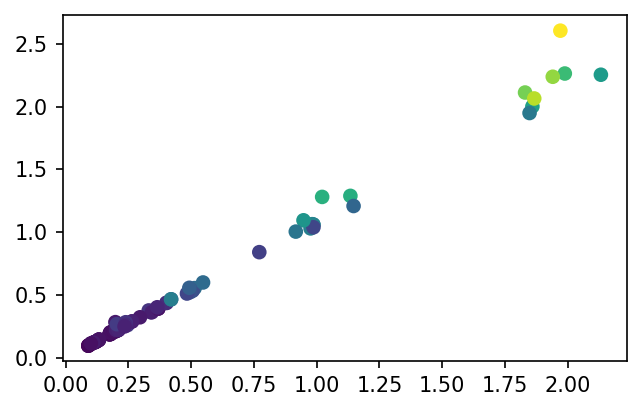

In [49]:
# is there really a difference between BT/DIC vs BT/HCO3
plt.scatter(dat.csys_mid.BT/dat.csys_mid.DIC, dat.csys_mid.BT/dat.csys_mid.HCO3, c=nom(dat[('Measured', 'B/Caf')]))

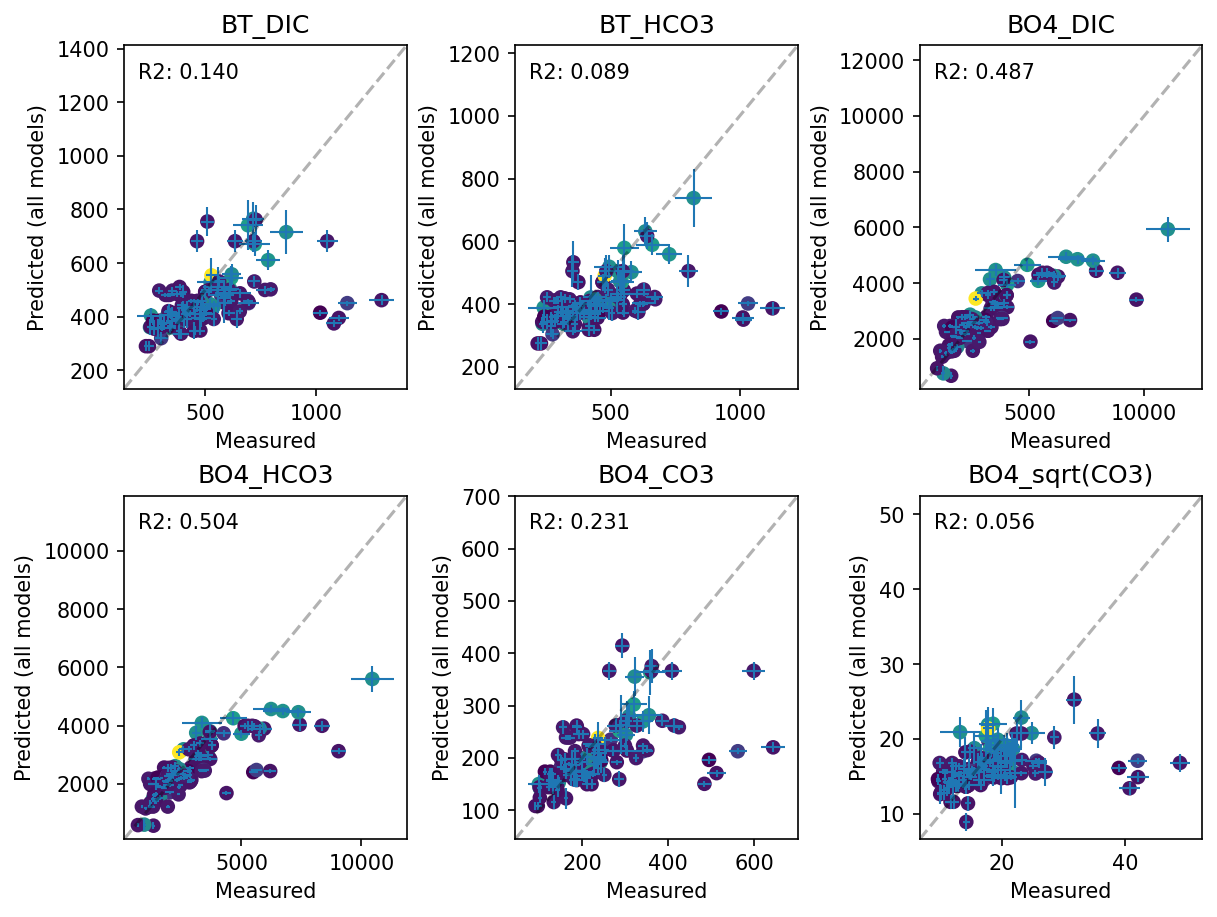

In [50]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    b = brutes[k]
    b.plot_obs_vs_pred(ax=ax, c=dat[('Measured', '[B]sw')])
    ax.set_title(k)
    ax.set_aspect('auto')
    lim = min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim,lim,ls='dashed',color=(0,0,0,0.3))
    r2 = bf.stats.calc_R2(b.y_orig.ravel(), b.pred_means)
    ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

In [51]:
# Convert KB to B/Ca for all models

pred_kb2bca = {}

for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        if b == 'BT' and c == 'CO3':
            continue
        ratio = f'{b}_{c}'
        print(ratio)
        kb_denom = (dat.loc[:, ('csys_mid', b)] / dat.loc[:, ('csys_mid', c)]).values
        pred_kb2bca[ratio] = brutes[ratio].pred_all * kb_denom

ratio = 'BO4_sqrt(CO3)'
print(ratio)
kb_denom = (dat.loc[:, ('csys_mid', 'BO4')] / dat.loc[:, ('csys_mid', 'CO3')]**0.5).values
pred_kb2bca[ratio] = brutes[ratio].pred_all * kb_denom

BT_DIC
BT_HCO3
BO4_DIC
BO4_HCO3
BO4_CO3
BO4_sqrt(CO3)


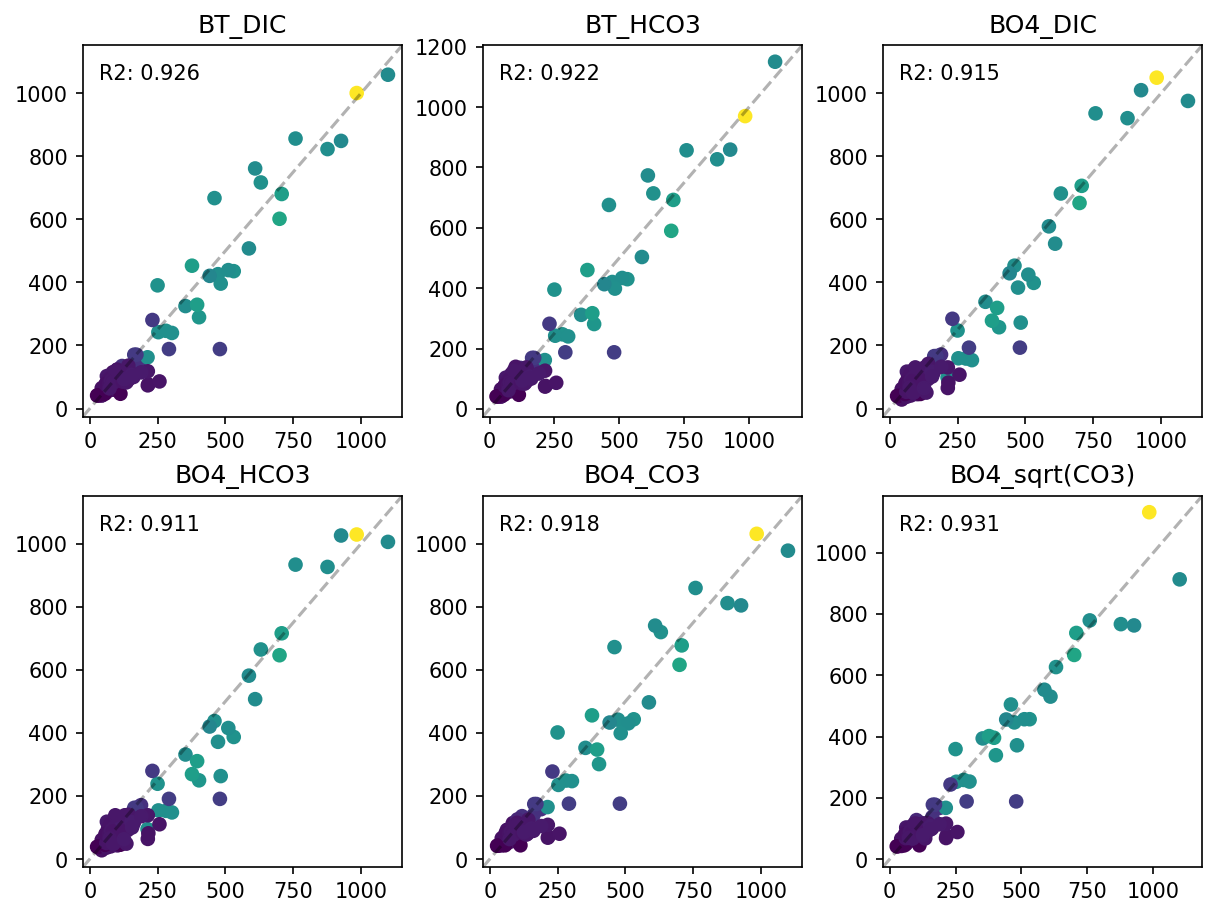

In [52]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    x = nom(dat.loc[:, ('Measured', 'B/Caf')])
    x_err = err(dat.loc[:, ('Measured', 'B/Caf')])
    y = pred_kb2bca[k].mean(0)
    y_err = pred_kb2bca[k].std(0)
    
    ax.scatter(x,y, c=dat.csys_mid.BT)
    
    ax.set_title(k)
    ax.set_aspect('auto')
    lim = min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim,lim,ls='dashed',color=(0,0,0,0.3))
    r2 = bf.stats.calc_R2(x, y)
    ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

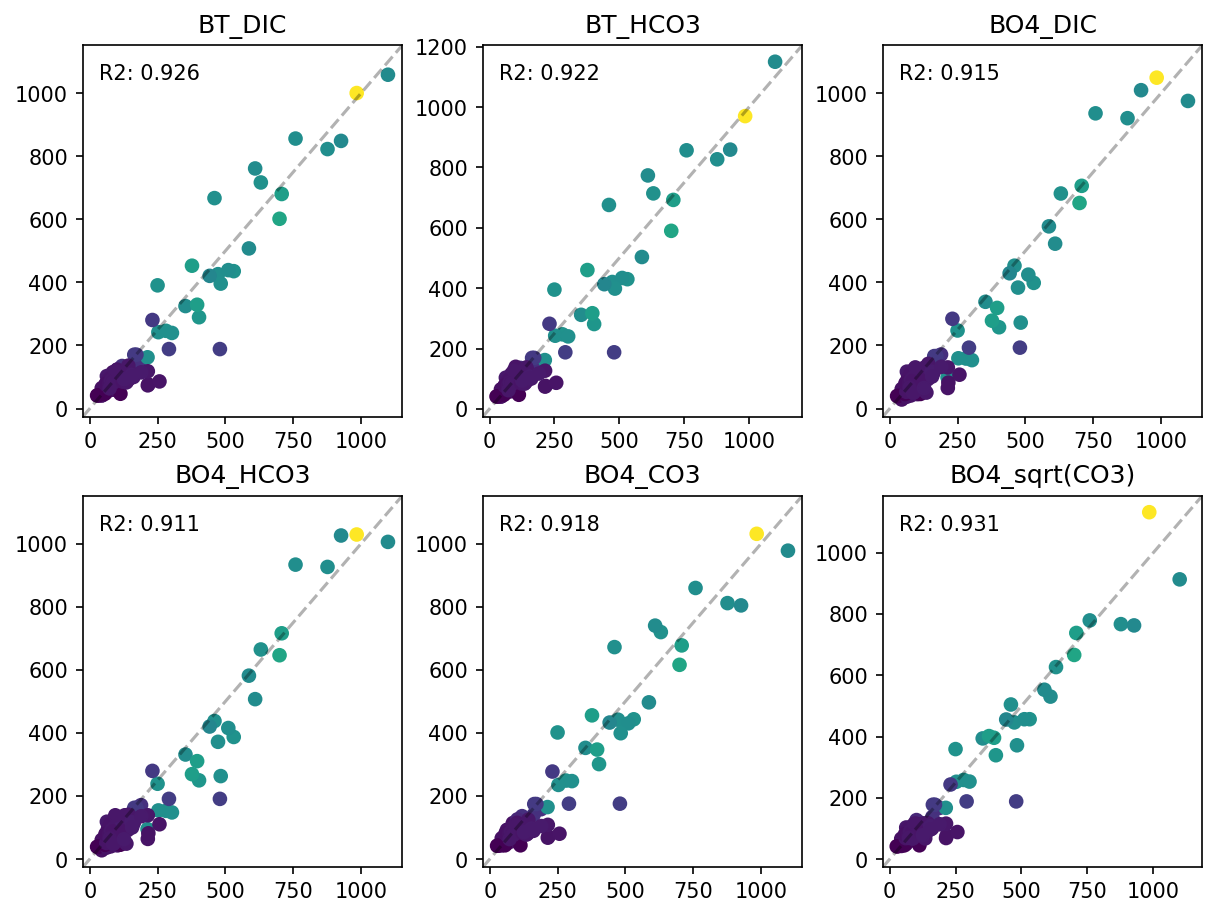

In [53]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    x = nom(dat.loc[:, ('Measured', 'B/Caf')])
    x_err = err(dat.loc[:, ('Measured', 'B/Caf')])
    y = pred_kb2bca[k].mean(0)
    y_err = pred_kb2bca[k].std(0)
    
    ax.scatter(x,y, c=dat.csys_mid.BT)
    
    ax.set_title(k)
    ax.set_aspect('auto')
    lim = min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim,lim,ls='dashed',color=(0,0,0,0.3))
    r2 = bf.stats.calc_R2(x, y)
    ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

## Model Taylor Diagrams

In [54]:
markers = {
    "BT_DIC": "o",
    "BT_HCO3": "s",
    "BO4_DIC": "<",
    "BO4_HCO3": ">",
    "BO4_CO3": "v",
}

labels = {
    "BT_DIC": "$B_T / DIC$",
    "BT_HCO3": "$B_T / HCO_3^-$",
    "BO4_DIC": "$B(OH)_4^- / DIC$",
    "BO4_HCO3": "$B(OH)_4^- / HCO_3^-$",
    "BO4_CO3": "$B(OH)_4^- / CO_3^{2-}$",
}

In [55]:
from b_funks.taylor_diag import Taylor_diag, make_Taylor_axis
from matplotlib.colors import Normalize

In [56]:
previous_models = fit_data_with_previous_models(dat)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log10 method

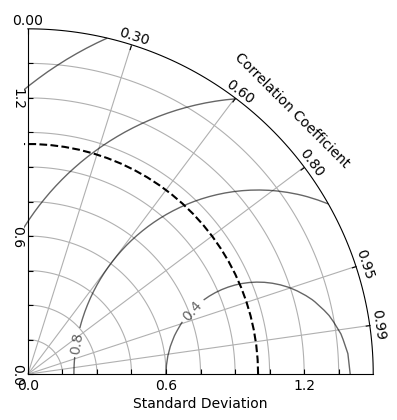

In [57]:
fig, ax = make_Taylor_axis(1.5, figsize=[10, 5])
# plot all brute models
vmin=-3
vmax=8
for k,v in pred_kb2bca.items():
    Taylor_diag(np.vstack([nom(dat.Measured['B/Caf'].values), v]), ax=ax, st_dev_max=1.5, marker=markers[k], s=20, label=labels[k], c=np.log10(brutes[k].modelfits.metrics.BF0), vmin=vmin, vmax=vmax)

# draw colorbar
cax = fig.add_axes([.55, .1, .02, .8])
fig.colorbar(plt.cm.ScalarMappable(Normalize(vmin=vmin, vmax=vmax)), cax=cax, label='$log_{10}$(Bayes Factor) [higher is better]')

# plot other bros

for k, v in previous_models['preds_all_data'].items():
    p = Taylor_diag(np.vstack([previous_models['ydata_all'][k], v]), ax=ax, label=k, marker='d', zorder=5)
    Taylor_diag(np.vstack([previous_models['ydata_training_conditions'][k], previous_models['preds_training_conditions'][k]]), ax=ax, facecolor=(0,0,0,0), lw=1, marker='d', edgecolor=p.get_facecolor(), zorder=4)

# draw legend
ax.legend(fontsize=8, bbox_to_anchor=[1.55, .1, .4, .8], loc='center left')


Fig 4 the papier?!

In [37]:
# fig, ax = make_Taylor_axis(2.5)

# var = 'DIC'

# for k,v in pred_kb2bca.items():
#     b = brutes[k]
#     var_ind = np.concatenate([[0], np.array(b.varnames) == var]).astype(bool)
#     var_present = ~b.modelfits.coefs.isnull().values[:, var_ind].flatten()  
    
#     # plot as present if in denominator
#     if var in k:
#         var_present = np.ones(b.modelfits.shape[0])
    
#     Taylor_diag(np.vstack([nom(dat.Measured['B/Caf'].values), v]), ax=ax, marker='o', s=20, label=k, c=var_present, vmin=0, vmax=1)

# fig.set_size_inches(5, 5)
# # ax.legend()

In [38]:
b.varnames

['[Ca]sw', '[Mg]sw', 'BO4', 'BT', 'CO3', 'pHtot', 'DIC']

In [39]:
mdict = {
    "BT_DIC": 'o',
    "BT_HCO3": 's',
    "BO4_DIC": 'd',
    "BO4_HCO3": 'v',
    "BO4_CO3": '^',
}

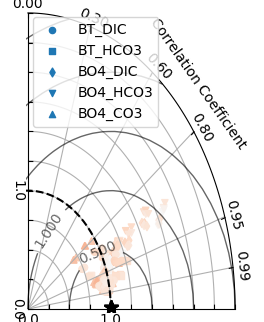

In [42]:
fig, ax = make_Taylor_axis(2.5)

var = '[Mg]sw'

vmin = -1
vmax = 1

for k,v in pred_kb2bca.items():
    b = brutes[k]
    var_ind = np.concatenate([[0], np.array(b.varnames) == var]).astype(bool)
    var_size = b.modelfits.coefs.values[:, var_ind].flatten()
    
    Taylor_diag(np.vstack([nom(dat.Measured['B/Caf'].values), v]), ax=ax, marker=mdict[k], s=20, label=k, c=var_size, vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r) # , lw=0.5, edgecolor=(.6,.6,.6))
    
# fig.set_size_inches(5, 5)
ax.legend()

Notes: the diagonal points are an artefact... not sure why they're there. Points with nan in the colour variable plot along a 45 degree line!? Only visible when edge-color specified.

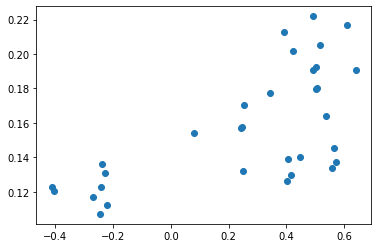

In [43]:
k = 'BT_DIC'
b = brutes[k]

xvar = 'pHtot'
yvar = '[Mg]sw'

xvar_ind = np.concatenate([[0], np.array(b.varnames) == xvar]).astype(bool)
xvar_size = b.modelfits.coefs.values[:, xvar_ind].flatten()

yvar_ind = np.concatenate([[0], np.array(b.varnames) == yvar]).astype(bool)
yvar_size = b.modelfits.coefs.values[:, yvar_ind].flatten()

plt.scatter(xvar_size, yvar_size)

(array([4., 4., 0., 0., 0., 0., 0., 1., 4., 3.]),
 array([-0.67453299, -0.57022806, -0.46592312, -0.36161819, -0.25731325,
        -0.15300832, -0.04870338,  0.05560155,  0.15990648,  0.26421142,
         0.36851635]),
 <BarContainer object of 10 artists>)

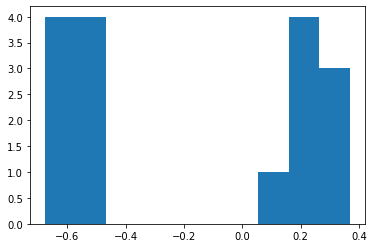

In [149]:
plt.hist(xvar_size)

## 'Best' Model

$$
\frac{B/Ca_{foram}}{[B] / [CO_3^{2-}]} = a [B(OH)_4^-] + b [B] + c [CO_3^{2-}]
$$

### Can this fit others' data (with an offset)?

In [48]:
mdict = {
    'This Study': 'o', 
    'Haynes et al. (2017)': 's', 
    'Allen et al. (2011)': 'd',
#     'Howes et al. (2017)': '*'
}

# variables used in fitting
target_vars = [('csys_mid', 'BO4'), ('csys_mid', 'BT'), ('csys_mid', 'CO3')]

# Kate's datas
ky = (kdat[('Measured', 'B/Caf')] / (kdat[('csys_mid', 'BT')] / kdat[('csys_mid', 'CO3')])).values.reshape(-1,1)
kX = kdat.loc[:, target_vars].values

# calculate scalers based on Kate's data
X_scaler = StandardScaler().fit(kX)
Y_scaler = StandardScaler().fit(ky)

# subset of other peoples' datas
tdat = odat.loc[odat.loc[:, ('Measured', 'who')].isin(mdict)]
tdat = tdat.loc[tdat.csys_mid.pHtot < 8.5]  # remove flyer in Kat's data

y = (tdat[('Measured', 'B/Caf')] / (tdat[('csys_mid', 'BT')] / tdat[('csys_mid', 'CO3')])).values.reshape(-1,1)
X = tdat.loc[:, target_vars].values

# transform others' datas
Xt = X_scaler.transform(X)
yt = Y_scaler.transform(y)

# Fit linear regression
model = LinearRegression(fit_intercept=False)

fit = model.fit(Xt, yt)
yp = fit.predict(Xt)

ypt = Y_scaler.inverse_transform(yp)

# compare to prediction using our best fit params
our_params = df.loc[0, 'coefs'].values[1:].astype(np.float)
our_params = our_params[~np.isnan(our_params)]

kyp = Xt.dot(our_params)
kypt = Y_scaler.inverse_transform(kyp)

fig, ax = plt.subplots()
ax.scatter(y, ypt, label="Best fit to others' data")
ax.scatter(y, kypt, label="Parameters from our best fit")

lim = ax.get_xlim()
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, ls='dashed', c=(0,0,0,0.5))

ax.legend()

ValueError: shapes (74,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

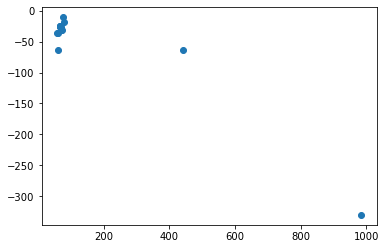

In [46]:
ypbca = ypt.flat * (tdat[('csys_mid', 'BT')] / tdat[('csys_mid', 'CO3')])
kypbca = kypt.flat * (tdat[('csys_mid', 'BT')] / tdat[('csys_mid', 'CO3')])


plt.scatter(tdat[('Measured', 'B/Caf')], ypbca - kypbca)
# plt.scatter(tdat[('Measured', 'B/Caf')], kypbca)

In [23]:
def c_offset(X, c):
    BCa, BT, CO3 = X 
    # Apply offset to others' B/Ca data
    oBCa = BCa + c
    # Caclulate partitioning
    return Y_scaler.transform((oBCa / (BT / CO3)).reshape(-1, 1))[:,0]

def m_offset(X, m):
    BCa, BT, CO3 = X 
    # Apply offset to others' B/Ca data
    oBCa = BCa * m
    # Caclulate partitioning
    return Y_scaler.transform((oBCa / (BT / CO3)).reshape(-1, 1))[:,0]

def cm_offset(X, c, m):
    BCa, BT, CO3 = X 
    # Apply offset to others' B/Ca data
    oBCa = c + BCa * m
    # Caclulate partitioning
    return Y_scaler.transform((oBCa / (BT / CO3)).reshape(-1, 1))[:,0]

In [24]:
Xu = tdat[('Measured', 'B/Caf')].values, tdat[('csys_mid', 'BT')].values, tdat[('csys_mid', 'CO3')].values

# constant offset
pc, covc = opt.curve_fit(c_offset, Xu, kyp.flat)
ypc = Y_scaler.inverse_transform(c_offset(Xu, *pc))

# multiplicative offset
pm, covm = opt.curve_fit(m_offset, Xu, kyp.flat)
ypm = Y_scaler.inverse_transform(m_offset(Xu, *pm))

# both offsets
pcm, covcm = opt.curve_fit(cm_offset, Xu, kyp.flat)
ypcm = Y_scaler.inverse_transform(cm_offset(Xu, *pcm))

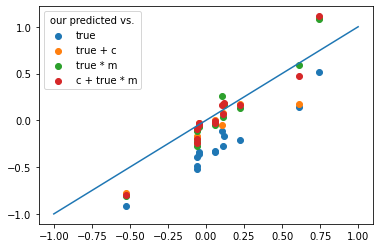

In [25]:
fig, ax = plt.subplots(1, 1)
ax.scatter(kyp, yt, label='true')
ax.scatter(kyp, c_offset(Xu, pc),  label='true + c')
ax.scatter(kyp, m_offset(Xu, pm), label='true * m')
ax.scatter(kyp, cm_offset(Xu, *pcm),  label='c + true * m')

lim = [-1., 1.]
ax.plot(lim, lim)
ax.legend(title='our predicted vs.')

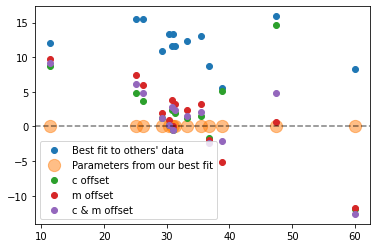

In [161]:
fig, ax = plt.subplots()
ax.scatter(y, kypt - ypt.flat, label="Best fit to others' data")
ax.scatter(y.flat, kypt - kypt, label="Parameters from our best fit", s=150, alpha=0.5)

ax.scatter(y, kypt - ypc, label="c offset")
ax.scatter(y, kypt - ypm, label="m offset")
ax.scatter(y, kypt - ypcm, label="c & m offset")

# lim = ax.get_xlim()
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.plot(lim, lim, ls='dashed', c=(0,0,0,0.5))
ax.axhline(0, ls='dashed', c=(0,0,0,0.5))

ax.legend()

In [205]:
# this isn't quite right - should be applying the offset to the B/Ca data then recalculating partitioning in fitting.

def c_offset(X, c):
    return c + X.dot(our_params)

def m_offset(X, m):
    return p[0] * X.dot(our_params)

def cm_offset(X, c, m):
    return c + m * X.dot(our_params)

In [206]:
# constant offset
pc, covc = opt.curve_fit(c_offset, Xt, yt.flat)
ypc = Y_scaler.inverse_transform(c_offset(Xt, *pc))
# multiplicative offset
pm, covm = opt.curve_fit(m_offset, Xt, yt.flat)
ypm = Y_scaler.inverse_transform(m_offset(Xt, *pm))
# both
pcm, covcm = opt.curve_fit(cm_offset, Xt, yt.flat)
ypcm = Y_scaler.inverse_transform(cm_offset(Xt, *pcm))


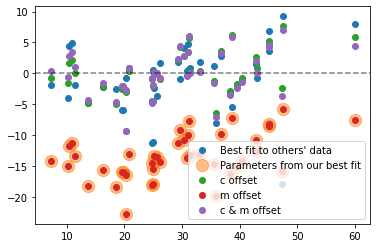

In [207]:
fig, ax = plt.subplots()
ax.scatter(y, y - ypt, label="Best fit to others' data")
ax.scatter(y.flat, y.flat - kypt, label="Parameters from our best fit", s=150, alpha=0.5)

ax.scatter(y, y.flat - ypc, label="c offset")
ax.scatter(y, y.flat - ypm, label="m offset")
ax.scatter(y, y.flat - ypcm, label="c & m offset")

# lim = ax.get_xlim()
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.plot(lim, lim, ls='dashed', c=(0,0,0,0.5))
ax.axhline(0, ls='dashed', c=(0,0,0,0.5))

ax.legend()

## K8 Plot

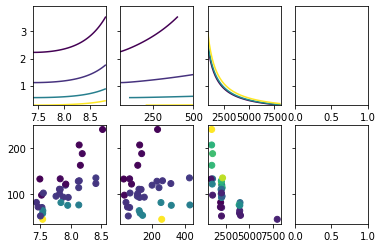

In [77]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey='row')

pH = np.linspace(7.4, 8.8)
DIC = np.linspace(900, 8100)
B = 420 * 5

xpH, xDIC = np.meshgrid(pH, DIC)

sw = cb.CBsys(pHtot=xpH, DIC=xDIC, BT=B, dBT=39.6)

ax = axs[0,0]
cvar = (sw.BT / sw.HCO3)
ax.contour(xpH, cvar, xDIC, [1000, 2000, 4000, 8000])

ax = axs[1,0]
ydat = dat.loc[:, ('Measured', 'B/Caf_corr')]
# ydat = dat.loc[:, ('Measured', 'KB')]
ax.scatter(dat.loc[:, ('csys_mid', 'pHtot')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])


ax = axs[0,1]
ax.contour(sw.CO3, cvar, xDIC, [1000, 2000, 4000, 8000])
ax.set_xlim(50, 500)

ax = axs[1,1]
ax.scatter(dat.loc[:, ('csys_mid', 'CO3')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])

ax = axs[0, 2]
ax.contour(xDIC, cvar, xpH, [7.6, 8, 8.4])

ax = axs[1,2]
ax.scatter(dat.loc[:, ('csys_mid', 'DIC')], ydat, c=dat.loc[:, ('csys_mid', 'pHtot')])


## Shambling Ground:

In [ ]:
# b.varnames

$$
B/Ca = a [CO3] + b \frac{B}{HCO3}
$$

In [ ]:
nmod = 1
# b = brutes[df.loc[nmod, 'r'][0]]
b = brutes

b.predict()
b.plot_obs_vs_pred()
plt.scatter(b.y_orig, b.pred_all[0, :], color='C1')

xlim = plt.gca().get_xlim()
plt.xlim(xlim)
plt.ylim(xlim)
plt.plot(xlim, xlim)

In [ ]:
b.modelfits

In [ ]:
dat.columns.shape

In [ ]:
resid = b.pred_all[0] - b.y_orig.T

nvar = b.X_orig.shape[1]

fig, axs = plt.subplots(nvar//2, 2, figsize=[nvar * 2.5, 6])

for i, ax in enumerate(axs.flat):
    ax.scatter(b.X_orig[:, i], resid, c=dat.loc[:, cvar])
    ax.set_xlabel(b.varnames[i])
    
fig.tight_layout()

In [ ]:
resid = b.pred_all[0] - b.y_orig.T

nvar = b.X_orig.shape[1]

fig, axs = plt.subplots(8, 8, figsize=[16,16])

for i, ax in enumerate(axs.flat):
    if i >= dat.shape[1]:
        continue
    if dat.dtypes[i] == 'O':
        continue
    ax.scatter(dat.loc[:, dat.columns[i]], resid)
    ax.set_xlabel(', '.join(dat.columns[i]))
    
fig.tight_layout()

In [ ]:
plt.scatter(dat.loc[:, ('csys_mid', 'CO3')], dat.loc[:, ('Measured', '[Ca]sw')], c=dat.loc[:, ('csys_mid', 'Omega')])
plt.colorbar()

## Pull this model out, fit it and look at the residuals!

In [ ]:
dat.Measured.columns

In [ ]:
plt.rcParams['figure.dpi'] = 150

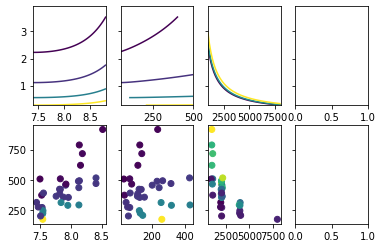

In [65]:
import cbsyst as cb

fig, axs = plt.subplots(2, 4, sharex=False, sharey='row')

pH = np.linspace(7.4, 8.8)
DIC = np.linspace(900, 8100)
B = 420 * 5

xpH, xDIC = np.meshgrid(pH, DIC)

sw = cb.CBsys(pHtot=xpH, DIC=xDIC, BT=B, dBT=39.6)

ax = axs[0,0]
cvar = (sw.BT / sw.HCO3)
ax.contour(xpH, cvar, xDIC, [1000, 2000, 4000, 8000])

ax = axs[1,0]
ydat = dat.loc[:, ('Measured', 'B/Caf')] / (dat.loc[:, ('Measured', '[B]sw')] / dat.loc[:, ('Measured', '[B]sw')].mean() )#/ (dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('csys_mid', 'HCO3')])
ax.scatter(dat.loc[:, ('csys_mid', 'pHtot')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])


ax = axs[0,1]
ax.contour(sw.CO3, cvar, xDIC, [1000, 2000, 4000, 8000])
ax.set_xlim(50, 500)

ax = axs[1,1]
ax.scatter(dat.loc[:, ('csys_mid', 'CO3')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])

ax = axs[0, 2]
ax.contour(xDIC, cvar, xpH, [7.6, 8, 8.4])

ax = axs[1,2]
ax.scatter(dat.loc[:, ('csys_mid', 'DIC')], ydat, c=dat.loc[:, ('csys_mid', 'pHtot')])


In [66]:
# cvar = ('Measured', '[Ca]sw')
# cvar = ('Measured', '[Mg]sw')
# cvar = ('csys_mid', 'Omega')
# cvar = ('csys_mid', 'CO3')
cvar = ('csys_mid', 'DIC')
# cvar = ('Measured', 'B umol/kg')

# bca_norm = dat.loc[:, ('Measured', 'B/Caf')] #/ (dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('Measured', 'B umol/kg')].mean())
y = dat.loc[:, ('Measured', 'KB')] #/ (dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('Measured', 'B umol/kg')].mean())

x = dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('csys_mid', 'DIC')]
# x = dat.loc[:, ('csys_mid', 'DIC')]

plt.scatter(x, y, c=dat.loc[:, cvar])

KeyError: ('Measured', 'B umol/kg')

In [ ]:
sdat.csys_mid

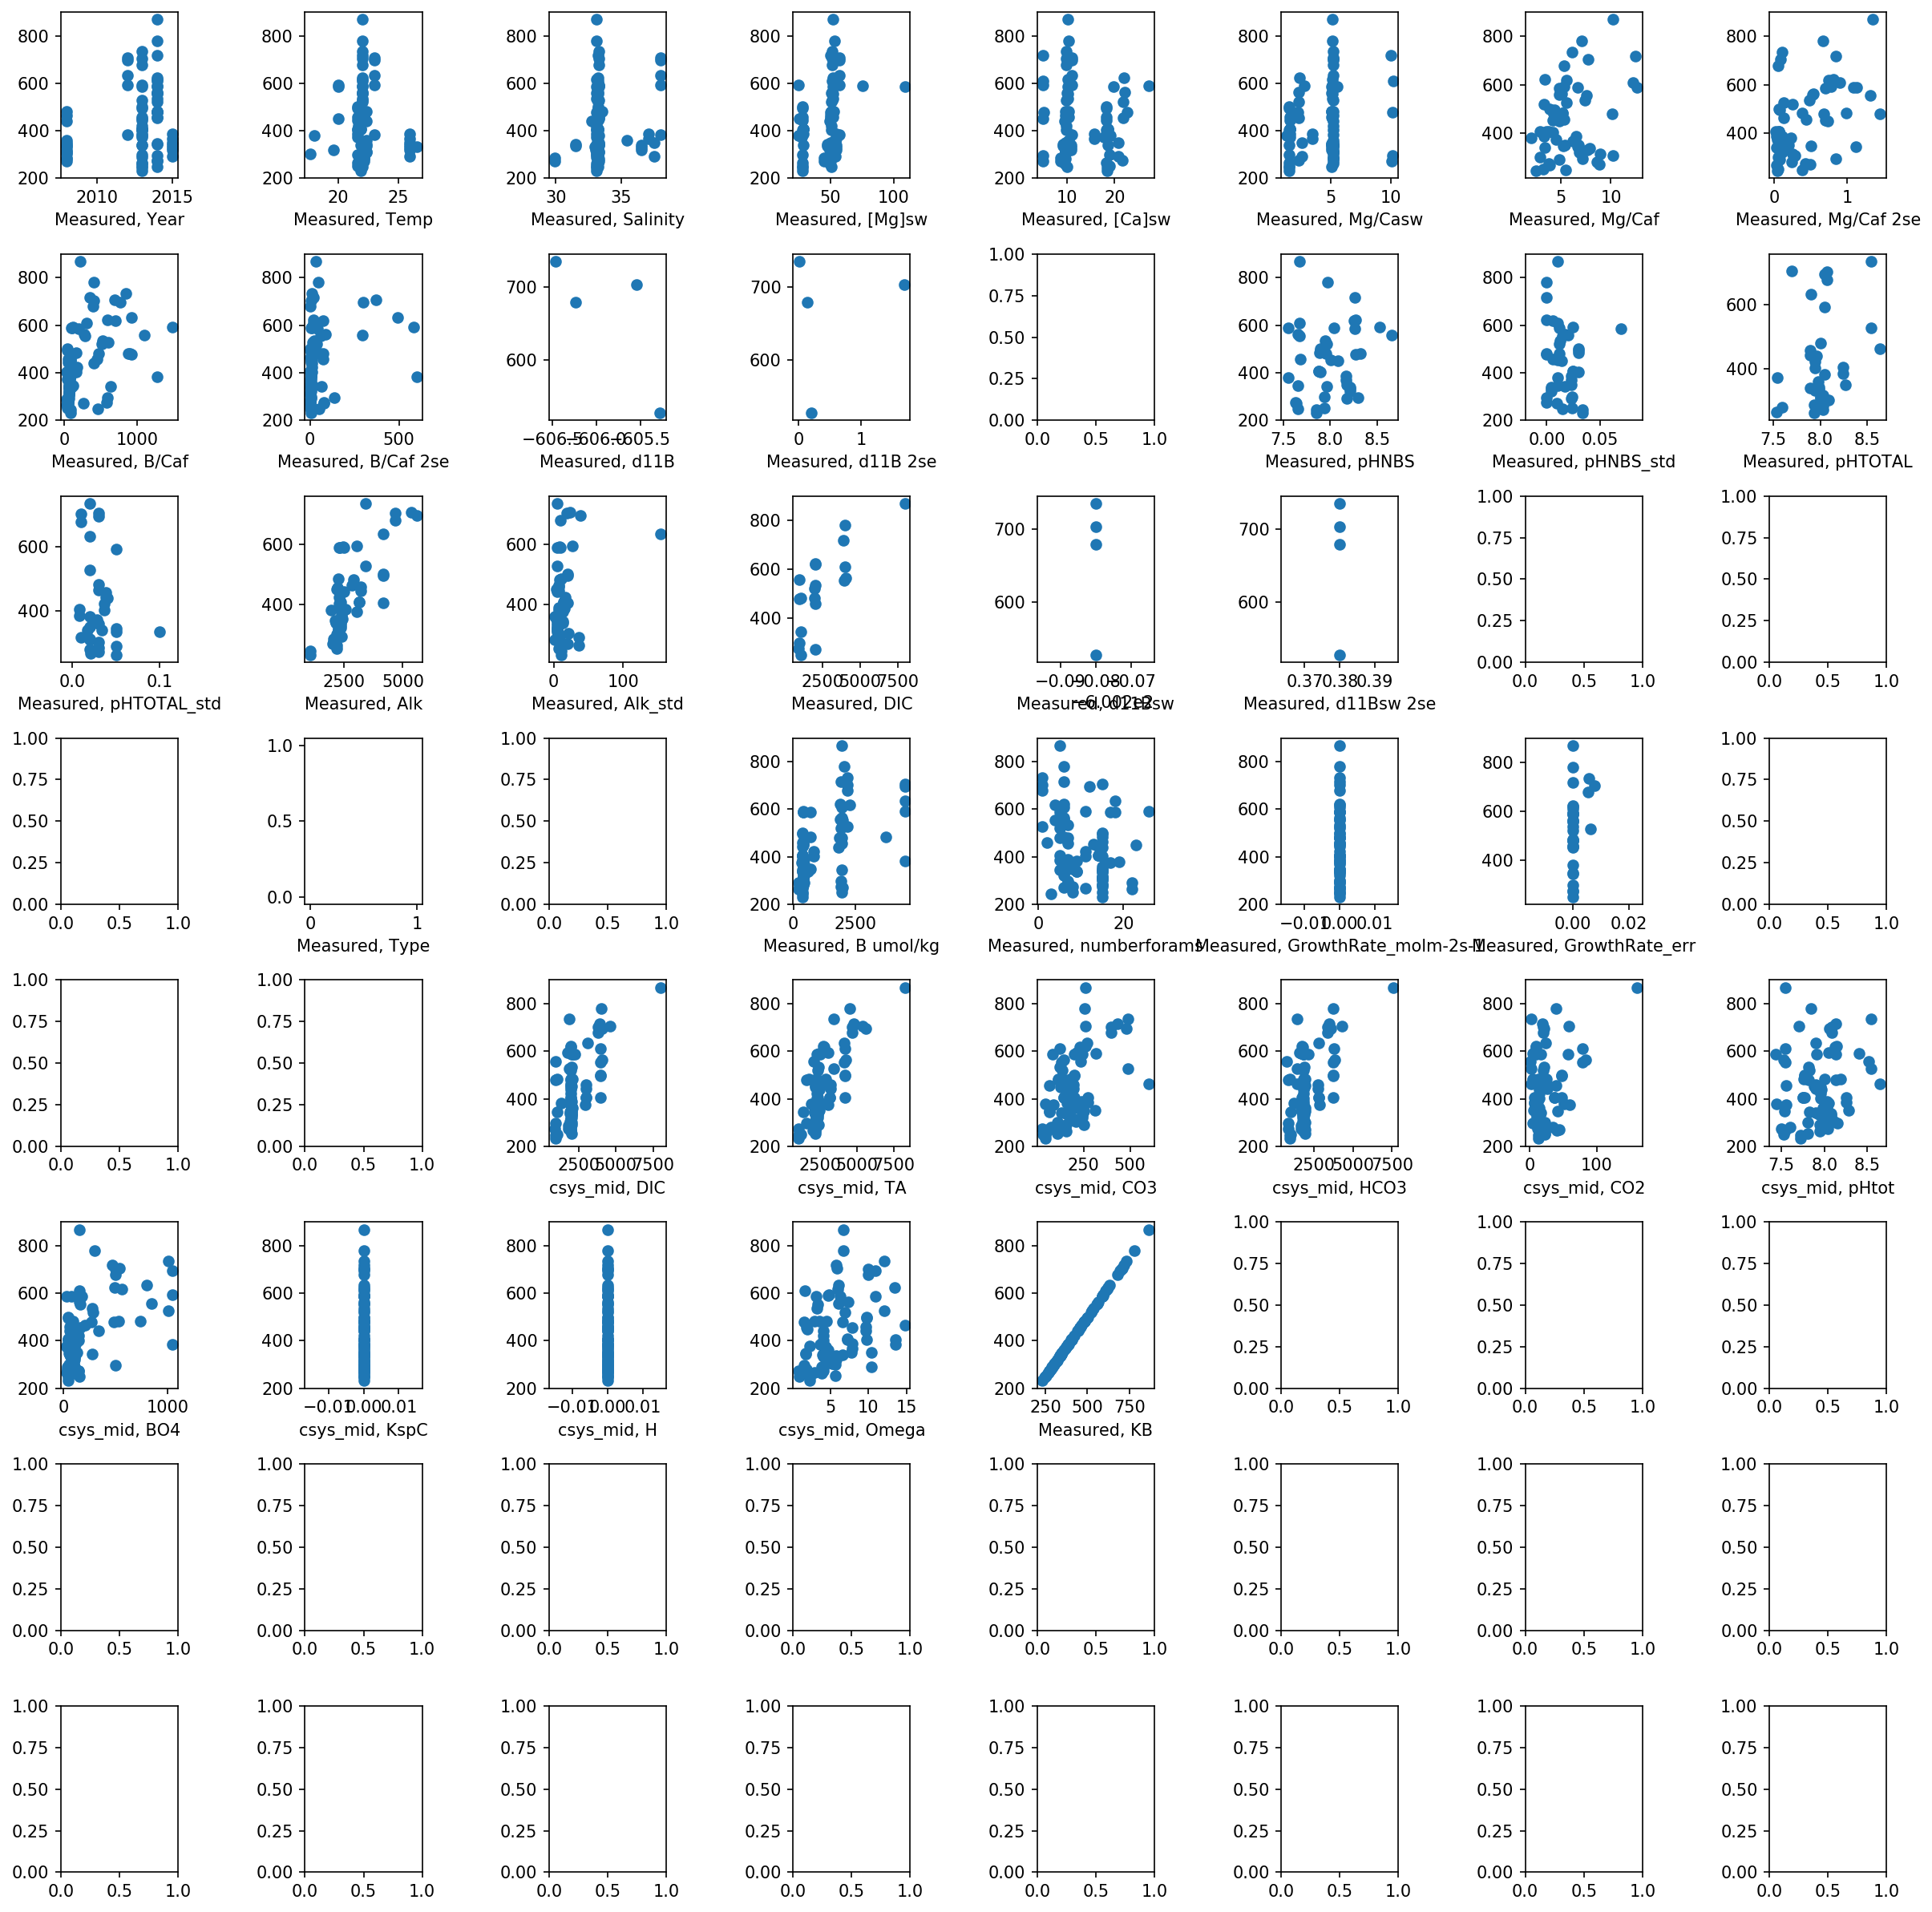

In [222]:
resid = dat.loc[:, ('Measured', 'KB')]

sdat = dat.loc[:, ['Measured', 'csys_mid']]
nvar = b.X_orig.shape[1]

fig, axs = plt.subplots(8, 8, figsize=[16,16])

i = 0
for ax in axs.flat:
    if i >= sdat.shape[1]:
        continue
    if sdat.dtypes[i] == 'O':
        i += 1
        continue
    ax.scatter(sdat.loc[:, sdat.columns[i]], resid)
    ax.set_xlabel(', '.join(sdat.columns[i]))
    i += 1

fig.tight_layout()